In [6]:
# Create Sliding Windows on the data series
import torch

def create_sliding_windows_with_target(data, window_size, shift=1):
    """
    Creates sliding windows from a sequence, splitting each window into features and target.

    Args:
        data: Input sequence (can be list, numpy array, or torch tensor)
        window_size: Size of each window
        shift: Number of elements to shift each window (stride)

    Returns:
        tuple: (features, targets) where:
            - features is a tensor of shape (num_windows, window_size-1)
            - targets is a tensor of shape (num_windows, 1)
    """
    # Convert input to tensor if it isn't already
    if not isinstance(data, torch.Tensor):
        data = torch.tensor(data, dtype=torch.float32)

    # Create windows using unfold
    windows = data.unfold(0, window_size, shift)

    # Split each window into features (all but last element) and target (last element)
    features = windows[:, :-1]  # All elements except the last
    targets = windows[:, -1:]   # Just the last element

    return features, targets


In [19]:
# If using Colab, make sure the station.csv data is uploaded. I've provided a sample
# in the downloads, but you can also get your own by following the instructions
# in the book text
def get_data():
    data_file = "station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [23]:
import numpy as np

def normalize_series(data, missing_value=999.9):
    # Convert to numpy array if not already
    data = np.array(data, dtype=np.float64)

    # Create mask for valid values (not NaN and not missing_value)
    valid_mask = (data != missing_value) & (~np.isnan(data))

    # Keep only valid values
    clean_data = data[valid_mask]

    # Normalize using only valid values
    mean = np.mean(clean_data)
    std = np.std(clean_data)
    normalized = (clean_data - mean) / std

    return normalized


time, series = get_data()
series_normalized = normalize_series(series)


Last 3 values before: [ 19.2   16.98 999.9  999.9  999.9 ]
Last 3 values after: [0.36722898 0.94666983 1.89308989 1.54542538 1.11663915]


In [25]:
print(len(series_normalized))

897


In [64]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np

# First create the full windowed dataset
series_tensor = torch.tensor(series_normalized, dtype=torch.float32)
window_size = 48
features, targets = create_sliding_windows_with_target(series_tensor, window_size=window_size, shift=1)

In [65]:
split_location = 800

features = features.unsqueeze(1)
# Create the full dataset
full_dataset = TensorDataset(features, targets)

# Calculate split indices
# Note: Since we're using windows, we need to account for the overlap
train_size = 800 - window_size + 1  # Adjust for window overlap
total_windows = len(full_dataset)
train_indices = list(range(train_size))
val_indices = list(range(train_size, total_windows))

# Create training and validation datasets using Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)



In [73]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print information about the splits
print(f"Original series length: {len(series_normalized)}")
print(f"Total number of windows: {total_windows}")
print(f"Training windows: {len(train_dataset)}")
print(f"Validation windows: {len(val_dataset)}")

# Show example batch from each
print("\nExample Training Batch:")
train_features, train_targets = next(iter(train_loader))
print(f"Batch shape - Features: {train_features.shape}, Targets: {train_targets.shape}")

print("\nExample Validation Batch:")
val_features, val_targets = next(iter(val_loader))
print(f"Batch shape - Features: {val_features.shape}, Targets: {val_targets.shape}")

Original series length: 897
Total number of windows: 850
Training windows: 753
Validation windows: 97

Example Training Batch:
Batch shape - Features: torch.Size([64, 1, 47]), Targets: torch.Size([64, 1])

Example Validation Batch:
Batch shape - Features: torch.Size([64, 1, 47]), Targets: torch.Size([64, 1])


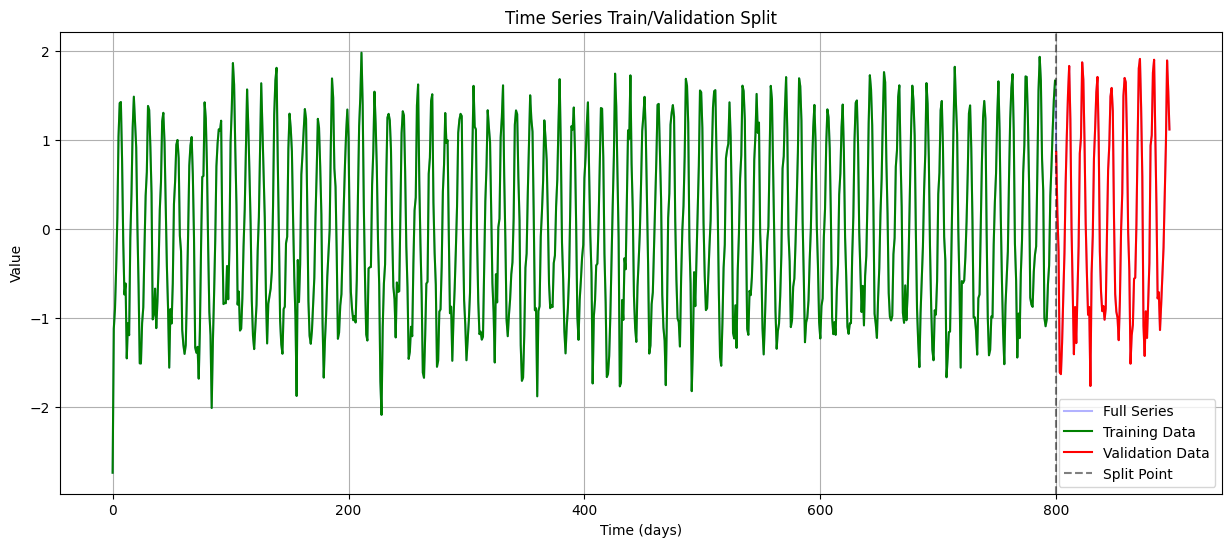

In [74]:
# Visualize the split point
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(range(len(series_normalized)), series_normalized, 'b-', label='Full Series', alpha=0.3)
plt.plot(range(split_location), series_normalized[:split_location], 'g-', label='Training Data')
plt.plot(range(split_location, len(series_normalized)), series_normalized[split_location:], 'r-', label='Validation Data')
plt.axvline(x=split_location, color='k', linestyle='--', alpha=0.5, label='Split Point')
plt.title('Time Series Train/Validation Split')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, dropout_rate=0.3):
        super(SimpleRNNModel, self).__init__()

        self.rnn1 = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          dropout=dropout_rate)  # Add dropout to RNN

        self.rnn2 = nn.RNN(input_size=hidden_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          dropout=dropout_rate)  # Add dropout to RNN

        self.dropout = nn.Dropout(dropout_rate)  # Additional dropout layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out1, _ = self.rnn1(x)
        out2, _ = self.rnn2(out1)
        last_out = out2[:, -1, :]
        last_out = self.dropout(last_out)  # Add dropout before final layer
        output = self.linear(last_out)
        return output





Epoch 1/500: 100%|██████████| 12/12 [00:00<00:00, 279.98it/s]


Epoch 1/500
Training Loss: 0.851844
Validation Loss: 0.872848
----------------------------------------




Epoch 2/500: 100%|██████████| 12/12 [00:00<00:00, 230.37it/s]


Epoch 2/500
Training Loss: 0.549803
Validation Loss: 0.560738
----------------------------------------




Epoch 3/500: 100%|██████████| 12/12 [00:00<00:00, 265.71it/s]


Epoch 3/500
Training Loss: 0.336772
Validation Loss: 0.343983
----------------------------------------




Epoch 4/500: 100%|██████████| 12/12 [00:00<00:00, 241.07it/s]


Epoch 4/500
Training Loss: 0.203139
Validation Loss: 0.215488
----------------------------------------




Epoch 5/500: 100%|██████████| 12/12 [00:00<00:00, 265.65it/s]


Epoch 5/500
Training Loss: 0.142004
Validation Loss: 0.154615
----------------------------------------




Epoch 6/500: 100%|██████████| 12/12 [00:00<00:00, 244.11it/s]


Epoch 6/500
Training Loss: 0.112330
Validation Loss: 0.132690
----------------------------------------




Epoch 7/500: 100%|██████████| 12/12 [00:00<00:00, 200.78it/s]


Epoch 7/500
Training Loss: 0.112025
Validation Loss: 0.124363
----------------------------------------




Epoch 8/500: 100%|██████████| 12/12 [00:00<00:00, 170.55it/s]


Epoch 8/500
Training Loss: 0.104853
Validation Loss: 0.119915
----------------------------------------




Epoch 9/500: 100%|██████████| 12/12 [00:00<00:00, 199.17it/s]


Epoch 9/500
Training Loss: 0.104845
Validation Loss: 0.116071
----------------------------------------




Epoch 10/500: 100%|██████████| 12/12 [00:00<00:00, 170.49it/s]


Epoch 10/500
Training Loss: 0.101511
Validation Loss: 0.112803
----------------------------------------




Epoch 11/500: 100%|██████████| 12/12 [00:00<00:00, 204.69it/s]


Epoch 11/500
Training Loss: 0.096659
Validation Loss: 0.109865
----------------------------------------




Epoch 12/500: 100%|██████████| 12/12 [00:00<00:00, 203.87it/s]


Epoch 12/500
Training Loss: 0.093823
Validation Loss: 0.107687
----------------------------------------




Epoch 13/500: 100%|██████████| 12/12 [00:00<00:00, 265.43it/s]


Epoch 13/500
Training Loss: 0.098020
Validation Loss: 0.105468
----------------------------------------




Epoch 14/500: 100%|██████████| 12/12 [00:00<00:00, 234.98it/s]


Epoch 14/500
Training Loss: 0.093780
Validation Loss: 0.102388
----------------------------------------




Epoch 15/500: 100%|██████████| 12/12 [00:00<00:00, 279.81it/s]


Epoch 15/500
Training Loss: 0.092336
Validation Loss: 0.101590
----------------------------------------




Epoch 16/500: 100%|██████████| 12/12 [00:00<00:00, 224.41it/s]


Epoch 16/500
Training Loss: 0.091194
Validation Loss: 0.100277
----------------------------------------




Epoch 17/500: 100%|██████████| 12/12 [00:00<00:00, 234.27it/s]


Epoch 17/500
Training Loss: 0.091405
Validation Loss: 0.099557
----------------------------------------




Epoch 18/500: 100%|██████████| 12/12 [00:00<00:00, 250.72it/s]


Epoch 18/500
Training Loss: 0.089222
Validation Loss: 0.098859
----------------------------------------




Epoch 19/500: 100%|██████████| 12/12 [00:00<00:00, 233.28it/s]


Epoch 19/500
Training Loss: 0.091875
Validation Loss: 0.097911
----------------------------------------




Epoch 20/500: 100%|██████████| 12/12 [00:00<00:00, 241.97it/s]


Epoch 20/500
Training Loss: 0.083708
Validation Loss: 0.096092
----------------------------------------




Epoch 21/500: 100%|██████████| 12/12 [00:00<00:00, 189.86it/s]


Epoch 21/500
Training Loss: 0.087081
Validation Loss: 0.095733
----------------------------------------




Epoch 22/500: 100%|██████████| 12/12 [00:00<00:00, 181.22it/s]


Epoch 22/500
Training Loss: 0.084651
Validation Loss: 0.094369
----------------------------------------




Epoch 23/500: 100%|██████████| 12/12 [00:00<00:00, 199.70it/s]


Epoch 23/500
Training Loss: 0.084112
Validation Loss: 0.092911
----------------------------------------




Epoch 24/500: 100%|██████████| 12/12 [00:00<00:00, 200.43it/s]


Epoch 24/500
Training Loss: 0.083525
Validation Loss: 0.093053
----------------------------------------




Epoch 25/500: 100%|██████████| 12/12 [00:00<00:00, 192.19it/s]


Epoch 25/500
Training Loss: 0.085287
Validation Loss: 0.092440
----------------------------------------




Epoch 26/500: 100%|██████████| 12/12 [00:00<00:00, 203.57it/s]


Epoch 26/500
Training Loss: 0.083769
Validation Loss: 0.092372
----------------------------------------




Epoch 27/500: 100%|██████████| 12/12 [00:00<00:00, 184.57it/s]


Epoch 27/500
Training Loss: 0.082793
Validation Loss: 0.090362
----------------------------------------




Epoch 28/500: 100%|██████████| 12/12 [00:00<00:00, 254.02it/s]


Epoch 28/500
Training Loss: 0.082338
Validation Loss: 0.090760
----------------------------------------




Epoch 29/500: 100%|██████████| 12/12 [00:00<00:00, 227.16it/s]


Epoch 29/500
Training Loss: 0.078093
Validation Loss: 0.089276
----------------------------------------




Epoch 30/500: 100%|██████████| 12/12 [00:00<00:00, 249.48it/s]


Epoch 30/500
Training Loss: 0.081299
Validation Loss: 0.088606
----------------------------------------




Epoch 31/500: 100%|██████████| 12/12 [00:00<00:00, 228.64it/s]


Epoch 31/500
Training Loss: 0.080401
Validation Loss: 0.087919
----------------------------------------




Epoch 32/500: 100%|██████████| 12/12 [00:00<00:00, 296.30it/s]


Epoch 32/500
Training Loss: 0.077651
Validation Loss: 0.087320
----------------------------------------




Epoch 33/500: 100%|██████████| 12/12 [00:00<00:00, 234.41it/s]


Epoch 33/500
Training Loss: 0.075554
Validation Loss: 0.085397
----------------------------------------




Epoch 34/500: 100%|██████████| 12/12 [00:00<00:00, 211.26it/s]


Epoch 34/500
Training Loss: 0.078188
Validation Loss: 0.085084
----------------------------------------




Epoch 35/500: 100%|██████████| 12/12 [00:00<00:00, 192.04it/s]


Epoch 35/500
Training Loss: 0.078413
Validation Loss: 0.085147
----------------------------------------




Epoch 36/500: 100%|██████████| 12/12 [00:00<00:00, 209.98it/s]


Epoch 36/500
Training Loss: 0.074595
Validation Loss: 0.084993
----------------------------------------




Epoch 37/500: 100%|██████████| 12/12 [00:00<00:00, 187.02it/s]


Epoch 37/500
Training Loss: 0.076868
Validation Loss: 0.084528
----------------------------------------




Epoch 38/500: 100%|██████████| 12/12 [00:00<00:00, 229.38it/s]


Epoch 38/500
Training Loss: 0.077212
Validation Loss: 0.083588
----------------------------------------




Epoch 39/500: 100%|██████████| 12/12 [00:00<00:00, 260.47it/s]


Epoch 39/500
Training Loss: 0.078372
Validation Loss: 0.083129
----------------------------------------




Epoch 40/500: 100%|██████████| 12/12 [00:00<00:00, 279.02it/s]


Epoch 40/500
Training Loss: 0.077951
Validation Loss: 0.082682
----------------------------------------




Epoch 41/500: 100%|██████████| 12/12 [00:00<00:00, 263.06it/s]


Epoch 41/500
Training Loss: 0.074910
Validation Loss: 0.082130
----------------------------------------




Epoch 42/500: 100%|██████████| 12/12 [00:00<00:00, 228.36it/s]


Epoch 42/500
Training Loss: 0.075725
Validation Loss: 0.081323
----------------------------------------




Epoch 43/500: 100%|██████████| 12/12 [00:00<00:00, 253.88it/s]


Epoch 43/500
Training Loss: 0.073733
Validation Loss: 0.080577
----------------------------------------




Epoch 44/500: 100%|██████████| 12/12 [00:00<00:00, 254.50it/s]


Epoch 44/500
Training Loss: 0.075259
Validation Loss: 0.082284
----------------------------------------




Epoch 45/500: 100%|██████████| 12/12 [00:00<00:00, 197.08it/s]


Epoch 45/500
Training Loss: 0.074861
Validation Loss: 0.080840
----------------------------------------




Epoch 46/500: 100%|██████████| 12/12 [00:00<00:00, 263.03it/s]


Epoch 46/500
Training Loss: 0.071799
Validation Loss: 0.080380
----------------------------------------




Epoch 47/500: 100%|██████████| 12/12 [00:00<00:00, 240.47it/s]


Epoch 47/500
Training Loss: 0.071990
Validation Loss: 0.079232
----------------------------------------




Epoch 48/500: 100%|██████████| 12/12 [00:00<00:00, 198.22it/s]


Epoch 48/500
Training Loss: 0.070412
Validation Loss: 0.079890
----------------------------------------




Epoch 49/500: 100%|██████████| 12/12 [00:00<00:00, 193.61it/s]


Epoch 49/500
Training Loss: 0.075623
Validation Loss: 0.081355
----------------------------------------




Epoch 50/500: 100%|██████████| 12/12 [00:00<00:00, 185.66it/s]


Epoch 50/500
Training Loss: 0.073456
Validation Loss: 0.079844
----------------------------------------




Epoch 51/500: 100%|██████████| 12/12 [00:00<00:00, 158.57it/s]


Epoch 51/500
Training Loss: 0.074683
Validation Loss: 0.078728
----------------------------------------




Epoch 52/500: 100%|██████████| 12/12 [00:00<00:00, 202.68it/s]


Epoch 52/500
Training Loss: 0.072729
Validation Loss: 0.079677
----------------------------------------




Epoch 53/500: 100%|██████████| 12/12 [00:00<00:00, 173.08it/s]


Epoch 53/500
Training Loss: 0.069693
Validation Loss: 0.078766
----------------------------------------




Epoch 54/500: 100%|██████████| 12/12 [00:00<00:00, 200.36it/s]


Epoch 54/500
Training Loss: 0.070798
Validation Loss: 0.077981
----------------------------------------




Epoch 55/500: 100%|██████████| 12/12 [00:00<00:00, 220.98it/s]


Epoch 55/500
Training Loss: 0.073652
Validation Loss: 0.078443
----------------------------------------




Epoch 56/500: 100%|██████████| 12/12 [00:00<00:00, 260.81it/s]


Epoch 56/500
Training Loss: 0.071689
Validation Loss: 0.076241
----------------------------------------




Epoch 57/500: 100%|██████████| 12/12 [00:00<00:00, 167.64it/s]


Epoch 57/500
Training Loss: 0.071835
Validation Loss: 0.078619
----------------------------------------




Epoch 58/500: 100%|██████████| 12/12 [00:00<00:00, 150.29it/s]


Epoch 58/500
Training Loss: 0.072273
Validation Loss: 0.078321
----------------------------------------




Epoch 59/500: 100%|██████████| 12/12 [00:00<00:00, 180.67it/s]


Epoch 59/500
Training Loss: 0.067664
Validation Loss: 0.077309
----------------------------------------




Epoch 60/500: 100%|██████████| 12/12 [00:00<00:00, 159.59it/s]


Epoch 60/500
Training Loss: 0.071628
Validation Loss: 0.077634
----------------------------------------




Epoch 61/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 61/500: 100%|██████████| 12/12 [00:00<00:00, 92.05it/s] 


Epoch 61/500
Training Loss: 0.071232
Validation Loss: 0.078236
----------------------------------------




Epoch 62/500: 100%|██████████| 12/12 [00:00<00:00, 152.00it/s]


Epoch 62/500
Training Loss: 0.070936
Validation Loss: 0.076523
----------------------------------------




Epoch 63/500: 100%|██████████| 12/12 [00:00<00:00, 168.21it/s]


Epoch 63/500
Training Loss: 0.070740
Validation Loss: 0.076277
----------------------------------------




Epoch 64/500: 100%|██████████| 12/12 [00:00<00:00, 180.84it/s]


Epoch 64/500
Training Loss: 0.070458
Validation Loss: 0.075698
----------------------------------------




Epoch 65/500: 100%|██████████| 12/12 [00:00<00:00, 177.44it/s]


Epoch 65/500
Training Loss: 0.070123
Validation Loss: 0.077316
----------------------------------------




Epoch 66/500: 100%|██████████| 12/12 [00:00<00:00, 161.97it/s]


Epoch 66/500
Training Loss: 0.068594
Validation Loss: 0.075669
----------------------------------------




Epoch 67/500: 100%|██████████| 12/12 [00:00<00:00, 173.95it/s]


Epoch 67/500
Training Loss: 0.069602
Validation Loss: 0.077619
----------------------------------------




Epoch 68/500: 100%|██████████| 12/12 [00:00<00:00, 169.20it/s]


Epoch 68/500
Training Loss: 0.070776
Validation Loss: 0.075548
----------------------------------------




Epoch 69/500: 100%|██████████| 12/12 [00:00<00:00, 144.70it/s]


Epoch 69/500
Training Loss: 0.071421
Validation Loss: 0.075022
----------------------------------------




Epoch 70/500: 100%|██████████| 12/12 [00:00<00:00, 165.01it/s]


Epoch 70/500
Training Loss: 0.071253
Validation Loss: 0.076423
----------------------------------------




Epoch 71/500: 100%|██████████| 12/12 [00:00<00:00, 143.81it/s]


Epoch 71/500
Training Loss: 0.068790
Validation Loss: 0.076258
----------------------------------------




Epoch 72/500: 100%|██████████| 12/12 [00:00<00:00, 167.62it/s]


Epoch 72/500
Training Loss: 0.070148
Validation Loss: 0.075820
----------------------------------------




Epoch 73/500: 100%|██████████| 12/12 [00:00<00:00, 135.68it/s]


Epoch 73/500
Training Loss: 0.064643
Validation Loss: 0.075296
----------------------------------------




Epoch 74/500: 100%|██████████| 12/12 [00:00<00:00, 186.66it/s]


Epoch 74/500
Training Loss: 0.067128
Validation Loss: 0.075599
----------------------------------------




Epoch 75/500: 100%|██████████| 12/12 [00:00<00:00, 175.49it/s]


Epoch 75/500
Training Loss: 0.066195
Validation Loss: 0.077643
----------------------------------------




Epoch 76/500: 100%|██████████| 12/12 [00:00<00:00, 191.82it/s]


Epoch 76/500
Training Loss: 0.068417
Validation Loss: 0.075046
----------------------------------------




Epoch 77/500: 100%|██████████| 12/12 [00:00<00:00, 174.19it/s]


Epoch 77/500
Training Loss: 0.067412
Validation Loss: 0.076013
----------------------------------------




Epoch 78/500: 100%|██████████| 12/12 [00:00<00:00, 166.55it/s]


Epoch 78/500
Training Loss: 0.066257
Validation Loss: 0.076182
----------------------------------------




Epoch 79/500: 100%|██████████| 12/12 [00:00<00:00, 170.34it/s]


Epoch 79/500
Training Loss: 0.066325
Validation Loss: 0.076196
----------------------------------------




Epoch 80/500: 100%|██████████| 12/12 [00:00<00:00, 126.94it/s]


Epoch 80/500
Training Loss: 0.069494
Validation Loss: 0.075112
----------------------------------------




Epoch 81/500: 100%|██████████| 12/12 [00:00<00:00, 143.04it/s]


Epoch 81/500
Training Loss: 0.070172
Validation Loss: 0.076800
----------------------------------------




Epoch 82/500: 100%|██████████| 12/12 [00:00<00:00, 120.67it/s]


Epoch 82/500
Training Loss: 0.067707
Validation Loss: 0.074954
----------------------------------------




Epoch 83/500: 100%|██████████| 12/12 [00:00<00:00, 121.22it/s]


Epoch 83/500
Training Loss: 0.068511
Validation Loss: 0.076397
----------------------------------------




Epoch 84/500: 100%|██████████| 12/12 [00:00<00:00, 126.08it/s]


Epoch 84/500
Training Loss: 0.066437
Validation Loss: 0.074621
----------------------------------------




Epoch 85/500: 100%|██████████| 12/12 [00:00<00:00, 143.92it/s]


Epoch 85/500
Training Loss: 0.066981
Validation Loss: 0.075151
----------------------------------------




Epoch 86/500: 100%|██████████| 12/12 [00:00<00:00, 145.81it/s]


Epoch 86/500
Training Loss: 0.067965
Validation Loss: 0.075707
----------------------------------------




Epoch 87/500: 100%|██████████| 12/12 [00:00<00:00, 169.06it/s]


Epoch 87/500
Training Loss: 0.069609
Validation Loss: 0.075676
----------------------------------------




Epoch 88/500: 100%|██████████| 12/12 [00:00<00:00, 172.50it/s]


Epoch 88/500
Training Loss: 0.066884
Validation Loss: 0.074994
----------------------------------------




Epoch 89/500: 100%|██████████| 12/12 [00:00<00:00, 157.71it/s]


Epoch 89/500
Training Loss: 0.065171
Validation Loss: 0.075291
----------------------------------------




Epoch 90/500: 100%|██████████| 12/12 [00:00<00:00, 125.16it/s]


Epoch 90/500
Training Loss: 0.065734
Validation Loss: 0.073777
----------------------------------------




Epoch 91/500: 100%|██████████| 12/12 [00:00<00:00, 144.38it/s]


Epoch 91/500
Training Loss: 0.070618
Validation Loss: 0.077228
----------------------------------------




Epoch 92/500: 100%|██████████| 12/12 [00:00<00:00, 172.41it/s]

Epoch 92/500
Training Loss: 0.068241
Validation Loss: 0.075915


----------------------------------------




Epoch 93/500: 100%|██████████| 12/12 [00:00<00:00, 169.81it/s]


Epoch 93/500
Training Loss: 0.068600
Validation Loss: 0.074598
----------------------------------------




Epoch 94/500: 100%|██████████| 12/12 [00:00<00:00, 183.98it/s]


Epoch 94/500
Training Loss: 0.067351
Validation Loss: 0.074416
----------------------------------------




Epoch 95/500: 100%|██████████| 12/12 [00:00<00:00, 175.83it/s]


Epoch 95/500
Training Loss: 0.065276
Validation Loss: 0.074882
----------------------------------------




Epoch 96/500: 100%|██████████| 12/12 [00:00<00:00, 168.45it/s]


Epoch 96/500
Training Loss: 0.068815
Validation Loss: 0.076421
----------------------------------------




Epoch 97/500: 100%|██████████| 12/12 [00:00<00:00, 167.51it/s]


Epoch 97/500
Training Loss: 0.064761
Validation Loss: 0.074101
----------------------------------------




Epoch 98/500: 100%|██████████| 12/12 [00:00<00:00, 163.84it/s]


Epoch 98/500
Training Loss: 0.066696
Validation Loss: 0.074405
----------------------------------------




Epoch 99/500: 100%|██████████| 12/12 [00:00<00:00, 178.04it/s]


Epoch 99/500
Training Loss: 0.066417
Validation Loss: 0.077011
----------------------------------------




Epoch 100/500: 100%|██████████| 12/12 [00:00<00:00, 120.69it/s]

Epoch 100/500


Training Loss: 0.066855
Validation Loss: 0.075448
----------------------------------------




Epoch 101/500: 100%|██████████| 12/12 [00:00<00:00, 123.56it/s]


Epoch 101/500
Training Loss: 0.066632
Validation Loss: 0.075149
----------------------------------------




Epoch 102/500: 100%|██████████| 12/12 [00:00<00:00, 119.91it/s]


Epoch 102/500
Training Loss: 0.068281
Validation Loss: 0.076664
----------------------------------------




Epoch 103/500: 100%|██████████| 12/12 [00:00<00:00, 137.85it/s]


Epoch 103/500
Training Loss: 0.065247
Validation Loss: 0.073405
----------------------------------------




Epoch 104/500: 100%|██████████| 12/12 [00:00<00:00, 148.57it/s]


Epoch 104/500
Training Loss: 0.064950
Validation Loss: 0.074001
----------------------------------------




Epoch 105/500: 100%|██████████| 12/12 [00:00<00:00, 152.93it/s]


Epoch 105/500
Training Loss: 0.066125
Validation Loss: 0.074779
----------------------------------------




Epoch 106/500: 100%|██████████| 12/12 [00:00<00:00, 259.58it/s]


Epoch 106/500
Training Loss: 0.067084
Validation Loss: 0.074777
----------------------------------------




Epoch 107/500: 100%|██████████| 12/12 [00:00<00:00, 220.84it/s]


Epoch 107/500
Training Loss: 0.065827
Validation Loss: 0.074516
----------------------------------------




Epoch 108/500: 100%|██████████| 12/12 [00:00<00:00, 246.45it/s]


Epoch 108/500
Training Loss: 0.068256
Validation Loss: 0.074046
----------------------------------------




Epoch 109/500: 100%|██████████| 12/12 [00:00<00:00, 180.16it/s]


Epoch 109/500
Training Loss: 0.065904
Validation Loss: 0.075139
----------------------------------------




Epoch 110/500: 100%|██████████| 12/12 [00:00<00:00, 247.42it/s]


Epoch 110/500
Training Loss: 0.066762
Validation Loss: 0.075149
----------------------------------------




Epoch 111/500: 100%|██████████| 12/12 [00:00<00:00, 173.82it/s]


Epoch 111/500
Training Loss: 0.065191
Validation Loss: 0.073949
----------------------------------------




Epoch 112/500: 100%|██████████| 12/12 [00:00<00:00, 179.48it/s]


Epoch 112/500
Training Loss: 0.063420
Validation Loss: 0.072469
----------------------------------------




Epoch 113/500: 100%|██████████| 12/12 [00:00<00:00, 142.67it/s]


Epoch 113/500
Training Loss: 0.064101
Validation Loss: 0.075734
----------------------------------------




Epoch 114/500: 100%|██████████| 12/12 [00:00<00:00, 192.30it/s]


Epoch 114/500
Training Loss: 0.065830
Validation Loss: 0.074469
----------------------------------------




Epoch 115/500: 100%|██████████| 12/12 [00:00<00:00, 215.73it/s]


Epoch 115/500
Training Loss: 0.063886
Validation Loss: 0.074001
----------------------------------------




Epoch 116/500: 100%|██████████| 12/12 [00:00<00:00, 244.36it/s]


Epoch 116/500
Training Loss: 0.062461
Validation Loss: 0.074444
----------------------------------------




Epoch 117/500: 100%|██████████| 12/12 [00:00<00:00, 216.38it/s]


Epoch 117/500
Training Loss: 0.061799
Validation Loss: 0.073017
----------------------------------------




Epoch 118/500: 100%|██████████| 12/12 [00:00<00:00, 231.30it/s]


Epoch 118/500
Training Loss: 0.065119
Validation Loss: 0.074932
----------------------------------------




Epoch 119/500: 100%|██████████| 12/12 [00:00<00:00, 278.84it/s]


Epoch 119/500
Training Loss: 0.063560
Validation Loss: 0.073282
----------------------------------------




Epoch 120/500: 100%|██████████| 12/12 [00:00<00:00, 218.84it/s]


Epoch 120/500
Training Loss: 0.065579
Validation Loss: 0.074058
----------------------------------------




Epoch 121/500: 100%|██████████| 12/12 [00:00<00:00, 264.51it/s]


Epoch 121/500
Training Loss: 0.064675
Validation Loss: 0.075067
----------------------------------------




Epoch 122/500: 100%|██████████| 12/12 [00:00<00:00, 232.78it/s]


Epoch 122/500
Training Loss: 0.061738
Validation Loss: 0.074185
----------------------------------------




Epoch 123/500: 100%|██████████| 12/12 [00:00<00:00, 272.22it/s]


Epoch 123/500
Training Loss: 0.065710
Validation Loss: 0.074430
----------------------------------------




Epoch 124/500: 100%|██████████| 12/12 [00:00<00:00, 186.67it/s]


Epoch 124/500
Training Loss: 0.068471
Validation Loss: 0.074679
----------------------------------------




Epoch 125/500: 100%|██████████| 12/12 [00:00<00:00, 153.60it/s]


Epoch 125/500
Training Loss: 0.065352
Validation Loss: 0.074810
----------------------------------------




Epoch 126/500: 100%|██████████| 12/12 [00:00<00:00, 170.75it/s]


Epoch 126/500
Training Loss: 0.065571
Validation Loss: 0.074777
----------------------------------------




Epoch 127/500: 100%|██████████| 12/12 [00:00<00:00, 141.64it/s]


Epoch 127/500
Training Loss: 0.065104
Validation Loss: 0.074736
----------------------------------------




Epoch 128/500: 100%|██████████| 12/12 [00:00<00:00, 168.61it/s]


Epoch 128/500
Training Loss: 0.066608
Validation Loss: 0.073807
----------------------------------------




Epoch 129/500: 100%|██████████| 12/12 [00:00<00:00, 190.25it/s]


Epoch 129/500
Training Loss: 0.066755
Validation Loss: 0.075318
----------------------------------------




Epoch 130/500: 100%|██████████| 12/12 [00:00<00:00, 221.95it/s]


Epoch 130/500
Training Loss: 0.064277
Validation Loss: 0.073832
----------------------------------------




Epoch 131/500: 100%|██████████| 12/12 [00:00<00:00, 215.14it/s]


Epoch 131/500
Training Loss: 0.063980
Validation Loss: 0.073619
----------------------------------------




Epoch 132/500: 100%|██████████| 12/12 [00:00<00:00, 232.44it/s]


Epoch 132/500
Training Loss: 0.064815
Validation Loss: 0.075342
----------------------------------------




Epoch 133/500: 100%|██████████| 12/12 [00:00<00:00, 231.80it/s]


Epoch 133/500
Training Loss: 0.064371
Validation Loss: 0.074656
----------------------------------------




Epoch 134/500: 100%|██████████| 12/12 [00:00<00:00, 219.95it/s]


Epoch 134/500
Training Loss: 0.065737
Validation Loss: 0.072656
----------------------------------------




Epoch 135/500: 100%|██████████| 12/12 [00:00<00:00, 214.67it/s]


Epoch 135/500
Training Loss: 0.063710
Validation Loss: 0.075002
----------------------------------------




Epoch 136/500: 100%|██████████| 12/12 [00:00<00:00, 184.93it/s]


Epoch 136/500
Training Loss: 0.063332
Validation Loss: 0.073835
----------------------------------------




Epoch 137/500: 100%|██████████| 12/12 [00:00<00:00, 171.45it/s]


Epoch 137/500
Training Loss: 0.061387
Validation Loss: 0.076133
----------------------------------------




Epoch 138/500: 100%|██████████| 12/12 [00:00<00:00, 190.88it/s]


Epoch 138/500
Training Loss: 0.066060
Validation Loss: 0.073574
----------------------------------------




Epoch 139/500: 100%|██████████| 12/12 [00:00<00:00, 182.40it/s]


Epoch 139/500
Training Loss: 0.064839
Validation Loss: 0.075319
----------------------------------------




Epoch 140/500: 100%|██████████| 12/12 [00:00<00:00, 146.86it/s]


Epoch 140/500
Training Loss: 0.063831
Validation Loss: 0.073909
----------------------------------------




Epoch 141/500: 100%|██████████| 12/12 [00:00<00:00, 267.60it/s]


Epoch 141/500
Training Loss: 0.064257
Validation Loss: 0.074723
----------------------------------------




Epoch 142/500: 100%|██████████| 12/12 [00:00<00:00, 226.69it/s]


Epoch 142/500
Training Loss: 0.064703
Validation Loss: 0.074495
----------------------------------------




Epoch 143/500: 100%|██████████| 12/12 [00:00<00:00, 232.18it/s]


Epoch 143/500
Training Loss: 0.061158
Validation Loss: 0.075539
----------------------------------------




Epoch 144/500: 100%|██████████| 12/12 [00:00<00:00, 259.74it/s]


Epoch 144/500
Training Loss: 0.065221
Validation Loss: 0.074797
----------------------------------------




Epoch 145/500: 100%|██████████| 12/12 [00:00<00:00, 219.22it/s]


Epoch 145/500
Training Loss: 0.066016
Validation Loss: 0.073418
----------------------------------------




Epoch 146/500: 100%|██████████| 12/12 [00:00<00:00, 241.48it/s]


Epoch 146/500
Training Loss: 0.061521
Validation Loss: 0.075190
----------------------------------------




Epoch 147/500: 100%|██████████| 12/12 [00:00<00:00, 230.51it/s]


Epoch 147/500
Training Loss: 0.067195
Validation Loss: 0.072869
----------------------------------------




Epoch 148/500: 100%|██████████| 12/12 [00:00<00:00, 263.39it/s]


Epoch 148/500
Training Loss: 0.064148
Validation Loss: 0.075500
----------------------------------------




Epoch 149/500: 100%|██████████| 12/12 [00:00<00:00, 207.37it/s]


Epoch 149/500
Training Loss: 0.064457
Validation Loss: 0.073394
----------------------------------------




Epoch 150/500: 100%|██████████| 12/12 [00:00<00:00, 186.57it/s]


Epoch 150/500
Training Loss: 0.061828
Validation Loss: 0.074614
----------------------------------------




Epoch 151/500: 100%|██████████| 12/12 [00:00<00:00, 156.90it/s]


Epoch 151/500
Training Loss: 0.063231
Validation Loss: 0.073481
----------------------------------------




Epoch 152/500: 100%|██████████| 12/12 [00:00<00:00, 192.84it/s]


Epoch 152/500
Training Loss: 0.065151
Validation Loss: 0.074676
----------------------------------------




Epoch 153/500: 100%|██████████| 12/12 [00:00<00:00, 155.47it/s]


Epoch 153/500
Training Loss: 0.063179
Validation Loss: 0.075386
----------------------------------------




Epoch 154/500: 100%|██████████| 12/12 [00:00<00:00, 169.14it/s]


Epoch 154/500
Training Loss: 0.061791
Validation Loss: 0.072916
----------------------------------------




Epoch 155/500: 100%|██████████| 12/12 [00:00<00:00, 229.49it/s]


Epoch 155/500
Training Loss: 0.064793
Validation Loss: 0.075076
----------------------------------------




Epoch 156/500: 100%|██████████| 12/12 [00:00<00:00, 220.82it/s]


Epoch 156/500
Training Loss: 0.063951
Validation Loss: 0.074119
----------------------------------------




Epoch 157/500: 100%|██████████| 12/12 [00:00<00:00, 269.98it/s]


Epoch 157/500
Training Loss: 0.062779
Validation Loss: 0.074802
----------------------------------------




Epoch 158/500: 100%|██████████| 12/12 [00:00<00:00, 229.80it/s]


Epoch 158/500
Training Loss: 0.063533
Validation Loss: 0.071992
----------------------------------------




Epoch 159/500: 100%|██████████| 12/12 [00:00<00:00, 237.00it/s]


Epoch 159/500
Training Loss: 0.061863
Validation Loss: 0.074595
----------------------------------------




Epoch 160/500: 100%|██████████| 12/12 [00:00<00:00, 247.56it/s]


Epoch 160/500
Training Loss: 0.063239
Validation Loss: 0.073619
----------------------------------------




Epoch 161/500: 100%|██████████| 12/12 [00:00<00:00, 259.20it/s]


Epoch 161/500
Training Loss: 0.062585
Validation Loss: 0.074730
----------------------------------------




Epoch 162/500: 100%|██████████| 12/12 [00:00<00:00, 172.26it/s]


Epoch 162/500
Training Loss: 0.064757
Validation Loss: 0.072407
----------------------------------------




Epoch 163/500: 100%|██████████| 12/12 [00:00<00:00, 171.36it/s]


Epoch 163/500
Training Loss: 0.063818
Validation Loss: 0.074123
----------------------------------------




Epoch 164/500: 100%|██████████| 12/12 [00:00<00:00, 164.35it/s]


Epoch 164/500
Training Loss: 0.065719
Validation Loss: 0.075182
----------------------------------------




Epoch 165/500: 100%|██████████| 12/12 [00:00<00:00, 157.34it/s]


Epoch 165/500
Training Loss: 0.064674
Validation Loss: 0.072809
----------------------------------------




Epoch 166/500: 100%|██████████| 12/12 [00:00<00:00, 154.00it/s]


Epoch 166/500
Training Loss: 0.063873
Validation Loss: 0.073336
----------------------------------------




Epoch 167/500: 100%|██████████| 12/12 [00:00<00:00, 154.61it/s]


Epoch 167/500
Training Loss: 0.063805
Validation Loss: 0.073734
----------------------------------------




Epoch 168/500: 100%|██████████| 12/12 [00:00<00:00, 239.98it/s]


Epoch 168/500
Training Loss: 0.063343
Validation Loss: 0.073925
----------------------------------------




Epoch 169/500: 100%|██████████| 12/12 [00:00<00:00, 216.57it/s]


Epoch 169/500
Training Loss: 0.063161
Validation Loss: 0.073590
----------------------------------------




Epoch 170/500: 100%|██████████| 12/12 [00:00<00:00, 251.13it/s]


Epoch 170/500
Training Loss: 0.062473
Validation Loss: 0.073658
----------------------------------------




Epoch 171/500: 100%|██████████| 12/12 [00:00<00:00, 199.87it/s]


Epoch 171/500
Training Loss: 0.064186
Validation Loss: 0.072394
----------------------------------------




Epoch 172/500: 100%|██████████| 12/12 [00:00<00:00, 253.04it/s]


Epoch 172/500
Training Loss: 0.064403
Validation Loss: 0.074185
----------------------------------------




Epoch 173/500: 100%|██████████| 12/12 [00:00<00:00, 264.18it/s]


Epoch 173/500
Training Loss: 0.066866
Validation Loss: 0.074822
----------------------------------------




Epoch 174/500: 100%|██████████| 12/12 [00:00<00:00, 141.79it/s]


Epoch 174/500
Training Loss: 0.064548
Validation Loss: 0.072971
----------------------------------------




Epoch 175/500: 100%|██████████| 12/12 [00:00<00:00, 167.11it/s]

Epoch 175/500
Training Loss: 0.065538
Validation Loss: 0.075686


----------------------------------------




Epoch 176/500: 100%|██████████| 12/12 [00:00<00:00, 156.15it/s]


Epoch 176/500
Training Loss: 0.064041
Validation Loss: 0.072242
----------------------------------------




Epoch 177/500: 100%|██████████| 12/12 [00:00<00:00, 173.71it/s]


Epoch 177/500
Training Loss: 0.061932
Validation Loss: 0.075889
----------------------------------------




Epoch 178/500: 100%|██████████| 12/12 [00:00<00:00, 186.79it/s]


Epoch 178/500
Training Loss: 0.062499
Validation Loss: 0.073594
----------------------------------------




Epoch 179/500: 100%|██████████| 12/12 [00:00<00:00, 157.41it/s]


Epoch 179/500
Training Loss: 0.062211
Validation Loss: 0.074267
----------------------------------------




Epoch 180/500: 100%|██████████| 12/12 [00:00<00:00, 203.81it/s]


Epoch 180/500
Training Loss: 0.062385
Validation Loss: 0.072936
----------------------------------------




Epoch 181/500: 100%|██████████| 12/12 [00:00<00:00, 216.41it/s]


Epoch 181/500
Training Loss: 0.062238
Validation Loss: 0.073100
----------------------------------------




Epoch 182/500: 100%|██████████| 12/12 [00:00<00:00, 234.10it/s]


Epoch 182/500
Training Loss: 0.062529
Validation Loss: 0.073186
----------------------------------------




Epoch 183/500: 100%|██████████| 12/12 [00:00<00:00, 191.32it/s]


Epoch 183/500
Training Loss: 0.063087
Validation Loss: 0.074058
----------------------------------------




Epoch 184/500: 100%|██████████| 12/12 [00:00<00:00, 241.66it/s]


Epoch 184/500
Training Loss: 0.067242
Validation Loss: 0.073249
----------------------------------------




Epoch 185/500: 100%|██████████| 12/12 [00:00<00:00, 213.25it/s]


Epoch 185/500
Training Loss: 0.063124
Validation Loss: 0.076735
----------------------------------------




Epoch 186/500: 100%|██████████| 12/12 [00:00<00:00, 175.83it/s]


Epoch 186/500
Training Loss: 0.062125
Validation Loss: 0.072520
----------------------------------------




Epoch 187/500: 100%|██████████| 12/12 [00:00<00:00, 164.87it/s]


Epoch 187/500
Training Loss: 0.063310
Validation Loss: 0.075191
----------------------------------------




Epoch 188/500: 100%|██████████| 12/12 [00:00<00:00, 171.08it/s]


Epoch 188/500
Training Loss: 0.061621
Validation Loss: 0.074640
----------------------------------------




Epoch 189/500: 100%|██████████| 12/12 [00:00<00:00, 181.58it/s]


Epoch 189/500
Training Loss: 0.062136
Validation Loss: 0.072226
----------------------------------------




Epoch 190/500: 100%|██████████| 12/12 [00:00<00:00, 178.17it/s]


Epoch 190/500
Training Loss: 0.064746
Validation Loss: 0.075052
----------------------------------------




Epoch 191/500: 100%|██████████| 12/12 [00:00<00:00, 201.21it/s]


Epoch 191/500
Training Loss: 0.061211
Validation Loss: 0.071780
----------------------------------------




Epoch 192/500: 100%|██████████| 12/12 [00:00<00:00, 182.79it/s]


Epoch 192/500
Training Loss: 0.064290
Validation Loss: 0.075563
----------------------------------------




Epoch 193/500: 100%|██████████| 12/12 [00:00<00:00, 241.50it/s]


Epoch 193/500
Training Loss: 0.062488
Validation Loss: 0.072468
----------------------------------------




Epoch 194/500: 100%|██████████| 12/12 [00:00<00:00, 211.37it/s]


Epoch 194/500
Training Loss: 0.061080
Validation Loss: 0.073440
----------------------------------------




Epoch 195/500: 100%|██████████| 12/12 [00:00<00:00, 243.29it/s]


Epoch 195/500
Training Loss: 0.061931
Validation Loss: 0.074044
----------------------------------------




Epoch 196/500: 100%|██████████| 12/12 [00:00<00:00, 227.97it/s]


Epoch 196/500
Training Loss: 0.063530
Validation Loss: 0.073962
----------------------------------------




Epoch 197/500: 100%|██████████| 12/12 [00:00<00:00, 224.75it/s]


Epoch 197/500
Training Loss: 0.063881
Validation Loss: 0.073206
----------------------------------------




Epoch 198/500: 100%|██████████| 12/12 [00:00<00:00, 166.00it/s]


Epoch 198/500
Training Loss: 0.063216
Validation Loss: 0.072452
----------------------------------------




Epoch 199/500: 100%|██████████| 12/12 [00:00<00:00, 180.68it/s]


Epoch 199/500
Training Loss: 0.063890
Validation Loss: 0.073104
----------------------------------------




Epoch 200/500: 100%|██████████| 12/12 [00:00<00:00, 165.40it/s]


Epoch 200/500
Training Loss: 0.062549
Validation Loss: 0.074486
----------------------------------------




Epoch 201/500: 100%|██████████| 12/12 [00:00<00:00, 172.52it/s]


Epoch 201/500
Training Loss: 0.065773
Validation Loss: 0.073336
----------------------------------------




Epoch 202/500: 100%|██████████| 12/12 [00:00<00:00, 174.77it/s]


Epoch 202/500
Training Loss: 0.059457
Validation Loss: 0.072745
----------------------------------------




Epoch 203/500: 100%|██████████| 12/12 [00:00<00:00, 227.87it/s]


Epoch 203/500
Training Loss: 0.065091
Validation Loss: 0.075585
----------------------------------------




Epoch 204/500: 100%|██████████| 12/12 [00:00<00:00, 243.29it/s]


Epoch 204/500
Training Loss: 0.061034
Validation Loss: 0.073025
----------------------------------------




Epoch 205/500: 100%|██████████| 12/12 [00:00<00:00, 174.21it/s]


Epoch 205/500
Training Loss: 0.063498
Validation Loss: 0.074029
----------------------------------------




Epoch 206/500: 100%|██████████| 12/12 [00:00<00:00, 242.89it/s]


Epoch 206/500
Training Loss: 0.063836
Validation Loss: 0.073437
----------------------------------------




Epoch 207/500: 100%|██████████| 12/12 [00:00<00:00, 219.90it/s]


Epoch 207/500
Training Loss: 0.058819
Validation Loss: 0.073583
----------------------------------------




Epoch 208/500: 100%|██████████| 12/12 [00:00<00:00, 214.37it/s]


Epoch 208/500
Training Loss: 0.060940
Validation Loss: 0.074070
----------------------------------------




Epoch 209/500: 100%|██████████| 12/12 [00:00<00:00, 206.84it/s]


Epoch 209/500
Training Loss: 0.063253
Validation Loss: 0.072913
----------------------------------------




Epoch 210/500: 100%|██████████| 12/12 [00:00<00:00, 193.01it/s]


Epoch 210/500
Training Loss: 0.061347
Validation Loss: 0.073211
----------------------------------------




Epoch 211/500: 100%|██████████| 12/12 [00:00<00:00, 165.96it/s]


Epoch 211/500
Training Loss: 0.060242
Validation Loss: 0.073744
----------------------------------------




Epoch 212/500: 100%|██████████| 12/12 [00:00<00:00, 177.99it/s]


Epoch 212/500
Training Loss: 0.063043
Validation Loss: 0.072029
----------------------------------------




Epoch 213/500: 100%|██████████| 12/12 [00:00<00:00, 174.93it/s]


Epoch 213/500
Training Loss: 0.060064
Validation Loss: 0.074615
----------------------------------------




Epoch 214/500: 100%|██████████| 12/12 [00:00<00:00, 175.81it/s]


Epoch 214/500
Training Loss: 0.060579
Validation Loss: 0.072482
----------------------------------------




Epoch 215/500: 100%|██████████| 12/12 [00:00<00:00, 243.70it/s]


Epoch 215/500
Training Loss: 0.060771
Validation Loss: 0.072706
----------------------------------------




Epoch 216/500: 100%|██████████| 12/12 [00:00<00:00, 222.81it/s]


Epoch 216/500
Training Loss: 0.065517
Validation Loss: 0.075064
----------------------------------------




Epoch 217/500: 100%|██████████| 12/12 [00:00<00:00, 229.52it/s]


Epoch 217/500
Training Loss: 0.063104
Validation Loss: 0.071512
----------------------------------------




Epoch 218/500: 100%|██████████| 12/12 [00:00<00:00, 196.37it/s]


Epoch 218/500
Training Loss: 0.062925
Validation Loss: 0.073698
----------------------------------------




Epoch 219/500: 100%|██████████| 12/12 [00:00<00:00, 195.38it/s]


Epoch 219/500
Training Loss: 0.060169
Validation Loss: 0.072116
----------------------------------------




Epoch 220/500: 100%|██████████| 12/12 [00:00<00:00, 211.62it/s]


Epoch 220/500
Training Loss: 0.059377
Validation Loss: 0.074992
----------------------------------------




Epoch 221/500: 100%|██████████| 12/12 [00:00<00:00, 204.20it/s]


Epoch 221/500
Training Loss: 0.060805
Validation Loss: 0.071413
----------------------------------------




Epoch 222/500: 100%|██████████| 12/12 [00:00<00:00, 204.44it/s]


Epoch 222/500
Training Loss: 0.063474
Validation Loss: 0.074069
----------------------------------------




Epoch 223/500: 100%|██████████| 12/12 [00:00<00:00, 169.00it/s]


Epoch 223/500
Training Loss: 0.064347
Validation Loss: 0.073222
----------------------------------------




Epoch 224/500: 100%|██████████| 12/12 [00:00<00:00, 155.90it/s]


Epoch 224/500
Training Loss: 0.063033
Validation Loss: 0.074043
----------------------------------------




Epoch 225/500: 100%|██████████| 12/12 [00:00<00:00, 176.62it/s]


Epoch 225/500
Training Loss: 0.061716
Validation Loss: 0.075068
----------------------------------------




Epoch 226/500: 100%|██████████| 12/12 [00:00<00:00, 153.50it/s]


Epoch 226/500
Training Loss: 0.060814
Validation Loss: 0.071680
----------------------------------------




Epoch 227/500: 100%|██████████| 12/12 [00:00<00:00, 172.81it/s]


Epoch 227/500
Training Loss: 0.059679
Validation Loss: 0.074453
----------------------------------------




Epoch 228/500: 100%|██████████| 12/12 [00:00<00:00, 203.21it/s]


Epoch 228/500
Training Loss: 0.062098
Validation Loss: 0.072429
----------------------------------------




Epoch 229/500: 100%|██████████| 12/12 [00:00<00:00, 228.06it/s]


Epoch 229/500
Training Loss: 0.060447
Validation Loss: 0.073695
----------------------------------------




Epoch 230/500: 100%|██████████| 12/12 [00:00<00:00, 154.76it/s]


Epoch 230/500
Training Loss: 0.060703
Validation Loss: 0.071878
----------------------------------------




Epoch 231/500: 100%|██████████| 12/12 [00:00<00:00, 166.25it/s]


Epoch 231/500
Training Loss: 0.061798
Validation Loss: 0.074865
----------------------------------------




Epoch 232/500: 100%|██████████| 12/12 [00:00<00:00, 168.09it/s]


Epoch 232/500
Training Loss: 0.060620
Validation Loss: 0.073096
----------------------------------------




Epoch 233/500: 100%|██████████| 12/12 [00:00<00:00, 156.17it/s]


Epoch 233/500
Training Loss: 0.062483
Validation Loss: 0.074153
----------------------------------------




Epoch 234/500: 100%|██████████| 12/12 [00:00<00:00, 140.46it/s]

Epoch 234/500


Training Loss: 0.063064
Validation Loss: 0.072653
----------------------------------------




Epoch 235/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 235/500: 100%|██████████| 12/12 [00:00<00:00, 104.12it/s]


Epoch 235/500
Training Loss: 0.062345
Validation Loss: 0.073700
----------------------------------------




Epoch 236/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 236/500: 100%|██████████| 12/12 [00:00<00:00, 104.71it/s]


Epoch 236/500
Training Loss: 0.062860
Validation Loss: 0.073334
----------------------------------------




Epoch 237/500: 100%|██████████| 12/12 [00:00<00:00, 136.13it/s]


Epoch 237/500
Training Loss: 0.062235
Validation Loss: 0.073555
----------------------------------------




Epoch 238/500: 100%|██████████| 12/12 [00:00<00:00, 147.97it/s]


Epoch 238/500
Training Loss: 0.062497
Validation Loss: 0.072511
----------------------------------------




Epoch 239/500: 100%|██████████| 12/12 [00:00<00:00, 196.87it/s]


Epoch 239/500
Training Loss: 0.060138
Validation Loss: 0.073780
----------------------------------------




Epoch 240/500: 100%|██████████| 12/12 [00:00<00:00, 176.74it/s]


Epoch 240/500
Training Loss: 0.061897
Validation Loss: 0.072810
----------------------------------------




Epoch 241/500: 100%|██████████| 12/12 [00:00<00:00, 158.30it/s]


Epoch 241/500
Training Loss: 0.062641
Validation Loss: 0.073941
----------------------------------------




Epoch 242/500: 100%|██████████| 12/12 [00:00<00:00, 161.06it/s]


Epoch 242/500
Training Loss: 0.061040
Validation Loss: 0.073239
----------------------------------------




Epoch 243/500: 100%|██████████| 12/12 [00:00<00:00, 183.97it/s]


Epoch 243/500
Training Loss: 0.062488
Validation Loss: 0.073656
----------------------------------------




Epoch 244/500: 100%|██████████| 12/12 [00:00<00:00, 144.62it/s]


Epoch 244/500
Training Loss: 0.060987
Validation Loss: 0.072416
----------------------------------------




Epoch 245/500: 100%|██████████| 12/12 [00:00<00:00, 117.50it/s]


Epoch 245/500
Training Loss: 0.062305
Validation Loss: 0.074843
----------------------------------------




Epoch 246/500: 100%|██████████| 12/12 [00:00<00:00, 119.78it/s]


Epoch 246/500
Training Loss: 0.060118
Validation Loss: 0.071325
----------------------------------------




Epoch 247/500: 100%|██████████| 12/12 [00:00<00:00, 133.30it/s]


Epoch 247/500
Training Loss: 0.062394
Validation Loss: 0.074349
----------------------------------------




Epoch 248/500: 100%|██████████| 12/12 [00:00<00:00, 182.95it/s]


Epoch 248/500
Training Loss: 0.061013
Validation Loss: 0.071386
----------------------------------------




Epoch 249/500: 100%|██████████| 12/12 [00:00<00:00, 174.60it/s]


Epoch 249/500
Training Loss: 0.059841
Validation Loss: 0.073285
----------------------------------------




Epoch 250/500: 100%|██████████| 12/12 [00:00<00:00, 198.19it/s]


Epoch 250/500
Training Loss: 0.060688
Validation Loss: 0.073790
----------------------------------------




Epoch 251/500: 100%|██████████| 12/12 [00:00<00:00, 161.89it/s]


Epoch 251/500
Training Loss: 0.062248
Validation Loss: 0.071593
----------------------------------------




Epoch 252/500: 100%|██████████| 12/12 [00:00<00:00, 123.59it/s]


Epoch 252/500
Training Loss: 0.060478
Validation Loss: 0.074185
----------------------------------------




Epoch 253/500: 100%|██████████| 12/12 [00:00<00:00, 190.46it/s]


Epoch 253/500
Training Loss: 0.059715
Validation Loss: 0.072657
----------------------------------------




Epoch 254/500: 100%|██████████| 12/12 [00:00<00:00, 160.19it/s]


Epoch 254/500
Training Loss: 0.058977
Validation Loss: 0.072587
----------------------------------------




Epoch 255/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 255/500: 100%|██████████| 12/12 [00:00<00:00, 88.41it/s] 


Epoch 255/500
Training Loss: 0.059268
Validation Loss: 0.072985
----------------------------------------




Epoch 256/500: 100%|██████████| 12/12 [00:00<00:00, 139.99it/s]


Epoch 256/500
Training Loss: 0.062332
Validation Loss: 0.072366
----------------------------------------




Epoch 257/500: 100%|██████████| 12/12 [00:00<00:00, 148.72it/s]


Epoch 257/500
Training Loss: 0.062000
Validation Loss: 0.074247
----------------------------------------




Epoch 258/500: 100%|██████████| 12/12 [00:00<00:00, 138.70it/s]


Epoch 258/500
Training Loss: 0.058206
Validation Loss: 0.072597
----------------------------------------




Epoch 259/500: 100%|██████████| 12/12 [00:00<00:00, 182.48it/s]


Epoch 259/500
Training Loss: 0.061468
Validation Loss: 0.074490
----------------------------------------




Epoch 260/500: 100%|██████████| 12/12 [00:00<00:00, 168.40it/s]


Epoch 260/500
Training Loss: 0.061737
Validation Loss: 0.072601
----------------------------------------




Epoch 261/500: 100%|██████████| 12/12 [00:00<00:00, 172.21it/s]


Epoch 261/500
Training Loss: 0.063021
Validation Loss: 0.073533
----------------------------------------




Epoch 262/500: 100%|██████████| 12/12 [00:00<00:00, 138.94it/s]


Epoch 262/500
Training Loss: 0.061212
Validation Loss: 0.073506
----------------------------------------




Epoch 263/500: 100%|██████████| 12/12 [00:00<00:00, 124.34it/s]


Epoch 263/500
Training Loss: 0.060266
Validation Loss: 0.073118
----------------------------------------




Epoch 264/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 264/500: 100%|██████████| 12/12 [00:00<00:00, 103.66it/s]


Epoch 264/500
Training Loss: 0.062100
Validation Loss: 0.073949
----------------------------------------




Epoch 265/500: 100%|██████████| 12/12 [00:00<00:00, 119.10it/s]


Epoch 265/500
Training Loss: 0.062206
Validation Loss: 0.071928
----------------------------------------




Epoch 266/500: 100%|██████████| 12/12 [00:00<00:00, 118.60it/s]


Epoch 266/500
Training Loss: 0.061796
Validation Loss: 0.072826
----------------------------------------




Epoch 267/500: 100%|██████████| 12/12 [00:00<00:00, 140.75it/s]


Epoch 267/500
Training Loss: 0.060782
Validation Loss: 0.072686
----------------------------------------




Epoch 268/500: 100%|██████████| 12/12 [00:00<00:00, 125.15it/s]


Epoch 268/500
Training Loss: 0.060907
Validation Loss: 0.071423
----------------------------------------




Epoch 269/500: 100%|██████████| 12/12 [00:00<00:00, 178.20it/s]


Epoch 269/500
Training Loss: 0.061412
Validation Loss: 0.073085
----------------------------------------




Epoch 270/500: 100%|██████████| 12/12 [00:00<00:00, 170.25it/s]


Epoch 270/500
Training Loss: 0.060160
Validation Loss: 0.072811
----------------------------------------




Epoch 271/500: 100%|██████████| 12/12 [00:00<00:00, 145.63it/s]


Epoch 271/500
Training Loss: 0.061663
Validation Loss: 0.073700
----------------------------------------




Epoch 272/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 272/500: 100%|██████████| 12/12 [00:00<00:00, 98.94it/s] 


Epoch 272/500
Training Loss: 0.059806
Validation Loss: 0.072576
----------------------------------------




Epoch 273/500: 100%|██████████| 12/12 [00:00<00:00, 139.22it/s]


Epoch 273/500
Training Loss: 0.064018
Validation Loss: 0.073566
----------------------------------------




Epoch 274/500: 100%|██████████| 12/12 [00:00<00:00, 160.38it/s]


Epoch 274/500
Training Loss: 0.063280
Validation Loss: 0.074407
----------------------------------------




Epoch 275/500: 100%|██████████| 12/12 [00:00<00:00, 178.81it/s]


Epoch 275/500
Training Loss: 0.061760
Validation Loss: 0.073724
----------------------------------------




Epoch 276/500: 100%|██████████| 12/12 [00:00<00:00, 180.17it/s]


Epoch 276/500
Training Loss: 0.059509
Validation Loss: 0.073498
----------------------------------------




Epoch 277/500: 100%|██████████| 12/12 [00:00<00:00, 167.41it/s]


Epoch 277/500
Training Loss: 0.060438
Validation Loss: 0.073281
----------------------------------------




Epoch 278/500: 100%|██████████| 12/12 [00:00<00:00, 181.90it/s]


Epoch 278/500
Training Loss: 0.063325
Validation Loss: 0.074841
----------------------------------------




Epoch 279/500: 100%|██████████| 12/12 [00:00<00:00, 174.84it/s]


Epoch 279/500
Training Loss: 0.061078
Validation Loss: 0.071109
----------------------------------------




Epoch 280/500: 100%|██████████| 12/12 [00:00<00:00, 170.63it/s]


Epoch 280/500
Training Loss: 0.060607
Validation Loss: 0.075577
----------------------------------------




Epoch 281/500: 100%|██████████| 12/12 [00:00<00:00, 181.72it/s]


Epoch 281/500
Training Loss: 0.059407
Validation Loss: 0.072746
----------------------------------------




Epoch 282/500: 100%|██████████| 12/12 [00:00<00:00, 169.77it/s]


Epoch 282/500
Training Loss: 0.062474
Validation Loss: 0.074580
----------------------------------------




Epoch 283/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 283/500: 100%|██████████| 12/12 [00:00<00:00, 101.72it/s]


Epoch 283/500
Training Loss: 0.060468
Validation Loss: 0.071360
----------------------------------------




Epoch 284/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 284/500: 100%|██████████| 12/12 [00:00<00:00, 104.85it/s]


Epoch 284/500
Training Loss: 0.062363
Validation Loss: 0.075122
----------------------------------------




Epoch 285/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 285/500: 100%|██████████| 12/12 [00:00<00:00, 97.07it/s] 


Epoch 285/500
Training Loss: 0.061455
Validation Loss: 0.072491
----------------------------------------




Epoch 286/500: 100%|██████████| 12/12 [00:00<00:00, 124.82it/s]


Epoch 286/500
Training Loss: 0.061222
Validation Loss: 0.074151
----------------------------------------




Epoch 287/500: 100%|██████████| 12/12 [00:00<00:00, 124.20it/s]


Epoch 287/500
Training Loss: 0.061241
Validation Loss: 0.072239
----------------------------------------




Epoch 288/500: 100%|██████████| 12/12 [00:00<00:00, 132.22it/s]


Epoch 288/500
Training Loss: 0.062810
Validation Loss: 0.073506
----------------------------------------




Epoch 289/500: 100%|██████████| 12/12 [00:00<00:00, 183.57it/s]


Epoch 289/500
Training Loss: 0.060017
Validation Loss: 0.072516
----------------------------------------




Epoch 290/500: 100%|██████████| 12/12 [00:00<00:00, 184.85it/s]


Epoch 290/500
Training Loss: 0.061393
Validation Loss: 0.072301
----------------------------------------




Epoch 291/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 291/500: 100%|██████████| 12/12 [00:00<00:00, 108.10it/s]


Epoch 291/500
Training Loss: 0.061986
Validation Loss: 0.072567
----------------------------------------




Epoch 292/500: 100%|██████████| 12/12 [00:00<00:00, 132.20it/s]


Epoch 292/500
Training Loss: 0.059937
Validation Loss: 0.071924
----------------------------------------




Epoch 293/500: 100%|██████████| 12/12 [00:00<00:00, 218.15it/s]


Epoch 293/500
Training Loss: 0.060459
Validation Loss: 0.073100
----------------------------------------




Epoch 294/500: 100%|██████████| 12/12 [00:00<00:00, 197.53it/s]


Epoch 294/500
Training Loss: 0.061066
Validation Loss: 0.073633
----------------------------------------




Epoch 295/500: 100%|██████████| 12/12 [00:00<00:00, 222.64it/s]


Epoch 295/500
Training Loss: 0.059302
Validation Loss: 0.072733
----------------------------------------




Epoch 296/500: 100%|██████████| 12/12 [00:00<00:00, 200.57it/s]


Epoch 296/500
Training Loss: 0.061646
Validation Loss: 0.071887
----------------------------------------




Epoch 297/500: 100%|██████████| 12/12 [00:00<00:00, 216.31it/s]


Epoch 297/500
Training Loss: 0.062034
Validation Loss: 0.072703
----------------------------------------




Epoch 298/500: 100%|██████████| 12/12 [00:00<00:00, 209.83it/s]


Epoch 298/500
Training Loss: 0.059956
Validation Loss: 0.071291
----------------------------------------




Epoch 299/500: 100%|██████████| 12/12 [00:00<00:00, 221.20it/s]


Epoch 299/500
Training Loss: 0.060350
Validation Loss: 0.075153
----------------------------------------




Epoch 300/500: 100%|██████████| 12/12 [00:00<00:00, 192.31it/s]


Epoch 300/500
Training Loss: 0.058591
Validation Loss: 0.071134
----------------------------------------




Epoch 301/500: 100%|██████████| 12/12 [00:00<00:00, 209.44it/s]


Epoch 301/500
Training Loss: 0.063104
Validation Loss: 0.075097
----------------------------------------




Epoch 302/500: 100%|██████████| 12/12 [00:00<00:00, 187.70it/s]


Epoch 302/500
Training Loss: 0.061015
Validation Loss: 0.074567
----------------------------------------




Epoch 303/500: 100%|██████████| 12/12 [00:00<00:00, 131.34it/s]


Epoch 303/500
Training Loss: 0.059417
Validation Loss: 0.072395
----------------------------------------




Epoch 304/500: 100%|██████████| 12/12 [00:00<00:00, 166.22it/s]


Epoch 304/500
Training Loss: 0.059562
Validation Loss: 0.072716
----------------------------------------




Epoch 305/500: 100%|██████████| 12/12 [00:00<00:00, 125.41it/s]


Epoch 305/500
Training Loss: 0.059083
Validation Loss: 0.071688
----------------------------------------




Epoch 306/500: 100%|██████████| 12/12 [00:00<00:00, 168.92it/s]


Epoch 306/500
Training Loss: 0.062262
Validation Loss: 0.072727
----------------------------------------




Epoch 307/500: 100%|██████████| 12/12 [00:00<00:00, 152.36it/s]


Epoch 307/500
Training Loss: 0.059530
Validation Loss: 0.073348
----------------------------------------




Epoch 308/500: 100%|██████████| 12/12 [00:00<00:00, 175.11it/s]


Epoch 308/500
Training Loss: 0.061835
Validation Loss: 0.074350
----------------------------------------




Epoch 309/500: 100%|██████████| 12/12 [00:00<00:00, 198.68it/s]


Epoch 309/500
Training Loss: 0.063136
Validation Loss: 0.072379
----------------------------------------




Epoch 310/500: 100%|██████████| 12/12 [00:00<00:00, 212.37it/s]


Epoch 310/500
Training Loss: 0.058494
Validation Loss: 0.073151
----------------------------------------




Epoch 311/500: 100%|██████████| 12/12 [00:00<00:00, 208.27it/s]


Epoch 311/500
Training Loss: 0.061181
Validation Loss: 0.072949
----------------------------------------




Epoch 312/500: 100%|██████████| 12/12 [00:00<00:00, 190.30it/s]


Epoch 312/500
Training Loss: 0.061540
Validation Loss: 0.073148
----------------------------------------




Epoch 313/500: 100%|██████████| 12/12 [00:00<00:00, 210.52it/s]


Epoch 313/500
Training Loss: 0.060627
Validation Loss: 0.074460
----------------------------------------




Epoch 314/500: 100%|██████████| 12/12 [00:00<00:00, 167.44it/s]


Epoch 314/500
Training Loss: 0.058413
Validation Loss: 0.073102
----------------------------------------




Epoch 315/500: 100%|██████████| 12/12 [00:00<00:00, 145.97it/s]


Epoch 315/500
Training Loss: 0.062884
Validation Loss: 0.072835
----------------------------------------




Epoch 316/500: 100%|██████████| 12/12 [00:00<00:00, 175.12it/s]


Epoch 316/500
Training Loss: 0.060286
Validation Loss: 0.073638
----------------------------------------




Epoch 317/500: 100%|██████████| 12/12 [00:00<00:00, 160.55it/s]


Epoch 317/500
Training Loss: 0.060238
Validation Loss: 0.071022
----------------------------------------




Epoch 318/500: 100%|██████████| 12/12 [00:00<00:00, 221.05it/s]


Epoch 318/500
Training Loss: 0.059223
Validation Loss: 0.075232
----------------------------------------




Epoch 319/500: 100%|██████████| 12/12 [00:00<00:00, 207.04it/s]


Epoch 319/500
Training Loss: 0.060692
Validation Loss: 0.071412
----------------------------------------




Epoch 320/500: 100%|██████████| 12/12 [00:00<00:00, 205.96it/s]


Epoch 320/500
Training Loss: 0.059526
Validation Loss: 0.073261
----------------------------------------




Epoch 321/500: 100%|██████████| 12/12 [00:00<00:00, 204.26it/s]


Epoch 321/500
Training Loss: 0.060697
Validation Loss: 0.073558
----------------------------------------




Epoch 322/500: 100%|██████████| 12/12 [00:00<00:00, 232.37it/s]


Epoch 322/500
Training Loss: 0.061761
Validation Loss: 0.073211
----------------------------------------




Epoch 323/500: 100%|██████████| 12/12 [00:00<00:00, 197.75it/s]


Epoch 323/500
Training Loss: 0.059787
Validation Loss: 0.074104
----------------------------------------




Epoch 324/500: 100%|██████████| 12/12 [00:00<00:00, 211.93it/s]


Epoch 324/500
Training Loss: 0.060356
Validation Loss: 0.072918
----------------------------------------




Epoch 325/500: 100%|██████████| 12/12 [00:00<00:00, 192.03it/s]


Epoch 325/500
Training Loss: 0.061725
Validation Loss: 0.073573
----------------------------------------




Epoch 326/500: 100%|██████████| 12/12 [00:00<00:00, 161.13it/s]


Epoch 326/500
Training Loss: 0.060151
Validation Loss: 0.074126
----------------------------------------




Epoch 327/500: 100%|██████████| 12/12 [00:00<00:00, 156.65it/s]


Epoch 327/500
Training Loss: 0.059079
Validation Loss: 0.072557
----------------------------------------




Epoch 328/500: 100%|██████████| 12/12 [00:00<00:00, 149.47it/s]


Epoch 328/500
Training Loss: 0.060921
Validation Loss: 0.071596
----------------------------------------




Epoch 329/500: 100%|██████████| 12/12 [00:00<00:00, 143.72it/s]


Epoch 329/500
Training Loss: 0.062658
Validation Loss: 0.072857
----------------------------------------




Epoch 330/500: 100%|██████████| 12/12 [00:00<00:00, 167.49it/s]


Epoch 330/500
Training Loss: 0.058319
Validation Loss: 0.073285
----------------------------------------




Epoch 331/500: 100%|██████████| 12/12 [00:00<00:00, 173.58it/s]


Epoch 331/500
Training Loss: 0.060479
Validation Loss: 0.071778
----------------------------------------




Epoch 332/500: 100%|██████████| 12/12 [00:00<00:00, 215.31it/s]


Epoch 332/500
Training Loss: 0.059376
Validation Loss: 0.073583
----------------------------------------




Epoch 333/500: 100%|██████████| 12/12 [00:00<00:00, 186.26it/s]


Epoch 333/500
Training Loss: 0.061243
Validation Loss: 0.072289
----------------------------------------




Epoch 334/500: 100%|██████████| 12/12 [00:00<00:00, 222.11it/s]


Epoch 334/500
Training Loss: 0.060035
Validation Loss: 0.074508
----------------------------------------




Epoch 335/500: 100%|██████████| 12/12 [00:00<00:00, 200.49it/s]


Epoch 335/500
Training Loss: 0.061205
Validation Loss: 0.071341
----------------------------------------




Epoch 336/500: 100%|██████████| 12/12 [00:00<00:00, 210.54it/s]


Epoch 336/500
Training Loss: 0.059811
Validation Loss: 0.072298
----------------------------------------




Epoch 337/500: 100%|██████████| 12/12 [00:00<00:00, 177.96it/s]


Epoch 337/500
Training Loss: 0.062392
Validation Loss: 0.071884
----------------------------------------




Epoch 338/500: 100%|██████████| 12/12 [00:00<00:00, 165.88it/s]


Epoch 338/500
Training Loss: 0.060622
Validation Loss: 0.072865
----------------------------------------




Epoch 339/500: 100%|██████████| 12/12 [00:00<00:00, 152.58it/s]


Epoch 339/500
Training Loss: 0.058041
Validation Loss: 0.072614
----------------------------------------




Epoch 340/500: 100%|██████████| 12/12 [00:00<00:00, 188.11it/s]


Epoch 340/500
Training Loss: 0.057913
Validation Loss: 0.072628
----------------------------------------




Epoch 341/500: 100%|██████████| 12/12 [00:00<00:00, 150.64it/s]


Epoch 341/500
Training Loss: 0.059700
Validation Loss: 0.073634
----------------------------------------




Epoch 342/500: 100%|██████████| 12/12 [00:00<00:00, 207.36it/s]


Epoch 342/500
Training Loss: 0.061794
Validation Loss: 0.071586
----------------------------------------




Epoch 343/500: 100%|██████████| 12/12 [00:00<00:00, 190.57it/s]


Epoch 343/500
Training Loss: 0.059034
Validation Loss: 0.072679
----------------------------------------




Epoch 344/500: 100%|██████████| 12/12 [00:00<00:00, 217.55it/s]


Epoch 344/500
Training Loss: 0.060816
Validation Loss: 0.073399
----------------------------------------




Epoch 345/500: 100%|██████████| 12/12 [00:00<00:00, 203.85it/s]


Epoch 345/500
Training Loss: 0.059656
Validation Loss: 0.072931
----------------------------------------




Epoch 346/500: 100%|██████████| 12/12 [00:00<00:00, 220.12it/s]


Epoch 346/500
Training Loss: 0.061750
Validation Loss: 0.073806
----------------------------------------




Epoch 347/500: 100%|██████████| 12/12 [00:00<00:00, 193.71it/s]


Epoch 347/500
Training Loss: 0.061316
Validation Loss: 0.073117
----------------------------------------




Epoch 348/500: 100%|██████████| 12/12 [00:00<00:00, 206.12it/s]


Epoch 348/500
Training Loss: 0.060324
Validation Loss: 0.072530
----------------------------------------




Epoch 349/500: 100%|██████████| 12/12 [00:00<00:00, 166.30it/s]


Epoch 349/500
Training Loss: 0.060472
Validation Loss: 0.073174
----------------------------------------




Epoch 350/500: 100%|██████████| 12/12 [00:00<00:00, 166.39it/s]


Epoch 350/500
Training Loss: 0.061076
Validation Loss: 0.073691
----------------------------------------




Epoch 351/500: 100%|██████████| 12/12 [00:00<00:00, 155.57it/s]


Epoch 351/500
Training Loss: 0.060198
Validation Loss: 0.071491
----------------------------------------




Epoch 352/500: 100%|██████████| 12/12 [00:00<00:00, 142.17it/s]


Epoch 352/500
Training Loss: 0.061450
Validation Loss: 0.072965
----------------------------------------




Epoch 353/500: 100%|██████████| 12/12 [00:00<00:00, 130.58it/s]


Epoch 353/500
Training Loss: 0.058881
Validation Loss: 0.073528
----------------------------------------




Epoch 354/500: 100%|██████████| 12/12 [00:00<00:00, 177.62it/s]


Epoch 354/500
Training Loss: 0.059038
Validation Loss: 0.071586
----------------------------------------




Epoch 355/500: 100%|██████████| 12/12 [00:00<00:00, 240.04it/s]


Epoch 355/500
Training Loss: 0.057585
Validation Loss: 0.072968
----------------------------------------




Epoch 356/500: 100%|██████████| 12/12 [00:00<00:00, 207.15it/s]


Epoch 356/500
Training Loss: 0.058449
Validation Loss: 0.072534
----------------------------------------




Epoch 357/500: 100%|██████████| 12/12 [00:00<00:00, 224.40it/s]


Epoch 357/500
Training Loss: 0.058715
Validation Loss: 0.072660
----------------------------------------




Epoch 358/500: 100%|██████████| 12/12 [00:00<00:00, 200.27it/s]


Epoch 358/500
Training Loss: 0.061884
Validation Loss: 0.073006
----------------------------------------




Epoch 359/500: 100%|██████████| 12/12 [00:00<00:00, 208.62it/s]


Epoch 359/500
Training Loss: 0.061063
Validation Loss: 0.073049
----------------------------------------




Epoch 360/500: 100%|██████████| 12/12 [00:00<00:00, 205.13it/s]


Epoch 360/500
Training Loss: 0.059888
Validation Loss: 0.072845
----------------------------------------




Epoch 361/500: 100%|██████████| 12/12 [00:00<00:00, 168.62it/s]


Epoch 361/500
Training Loss: 0.058475
Validation Loss: 0.073818
----------------------------------------




Epoch 362/500: 100%|██████████| 12/12 [00:00<00:00, 152.04it/s]


Epoch 362/500
Training Loss: 0.058832
Validation Loss: 0.073086
----------------------------------------




Epoch 363/500: 100%|██████████| 12/12 [00:00<00:00, 186.24it/s]


Epoch 363/500
Training Loss: 0.059676
Validation Loss: 0.072068
----------------------------------------




Epoch 364/500: 100%|██████████| 12/12 [00:00<00:00, 164.17it/s]


Epoch 364/500
Training Loss: 0.059282
Validation Loss: 0.074898
----------------------------------------




Epoch 365/500: 100%|██████████| 12/12 [00:00<00:00, 178.48it/s]


Epoch 365/500
Training Loss: 0.059373
Validation Loss: 0.072006
----------------------------------------




Epoch 366/500: 100%|██████████| 12/12 [00:00<00:00, 163.51it/s]


Epoch 366/500
Training Loss: 0.060502
Validation Loss: 0.071550
----------------------------------------




Epoch 367/500: 100%|██████████| 12/12 [00:00<00:00, 195.23it/s]


Epoch 367/500
Training Loss: 0.060217
Validation Loss: 0.072468
----------------------------------------




Epoch 368/500: 100%|██████████| 12/12 [00:00<00:00, 207.90it/s]


Epoch 368/500
Training Loss: 0.061554
Validation Loss: 0.073709
----------------------------------------




Epoch 369/500: 100%|██████████| 12/12 [00:00<00:00, 198.18it/s]


Epoch 369/500
Training Loss: 0.061017
Validation Loss: 0.073238
----------------------------------------




Epoch 370/500: 100%|██████████| 12/12 [00:00<00:00, 201.91it/s]


Epoch 370/500
Training Loss: 0.058684
Validation Loss: 0.073151
----------------------------------------




Epoch 371/500: 100%|██████████| 12/12 [00:00<00:00, 205.27it/s]


Epoch 371/500
Training Loss: 0.060513
Validation Loss: 0.074486
----------------------------------------




Epoch 372/500: 100%|██████████| 12/12 [00:00<00:00, 219.35it/s]


Epoch 372/500
Training Loss: 0.058397
Validation Loss: 0.072492
----------------------------------------




Epoch 373/500: 100%|██████████| 12/12 [00:00<00:00, 160.72it/s]


Epoch 373/500
Training Loss: 0.058032
Validation Loss: 0.072074
----------------------------------------




Epoch 374/500: 100%|██████████| 12/12 [00:00<00:00, 160.45it/s]


Epoch 374/500
Training Loss: 0.057534
Validation Loss: 0.071092
----------------------------------------




Epoch 375/500: 100%|██████████| 12/12 [00:00<00:00, 157.02it/s]


Epoch 375/500
Training Loss: 0.058020
Validation Loss: 0.075883
----------------------------------------




Epoch 376/500: 100%|██████████| 12/12 [00:00<00:00, 166.55it/s]


Epoch 376/500
Training Loss: 0.060369
Validation Loss: 0.071253
----------------------------------------




Epoch 377/500: 100%|██████████| 12/12 [00:00<00:00, 152.34it/s]


Epoch 377/500
Training Loss: 0.058277
Validation Loss: 0.074302
----------------------------------------




Epoch 378/500: 100%|██████████| 12/12 [00:00<00:00, 178.42it/s]


Epoch 378/500
Training Loss: 0.059992
Validation Loss: 0.071694
----------------------------------------




Epoch 379/500: 100%|██████████| 12/12 [00:00<00:00, 203.46it/s]


Epoch 379/500
Training Loss: 0.059582
Validation Loss: 0.073157
----------------------------------------




Epoch 380/500: 100%|██████████| 12/12 [00:00<00:00, 216.54it/s]


Epoch 380/500
Training Loss: 0.058882
Validation Loss: 0.073337
----------------------------------------




Epoch 381/500: 100%|██████████| 12/12 [00:00<00:00, 191.27it/s]


Epoch 381/500
Training Loss: 0.059226
Validation Loss: 0.074086
----------------------------------------




Epoch 382/500: 100%|██████████| 12/12 [00:00<00:00, 209.67it/s]


Epoch 382/500
Training Loss: 0.060632
Validation Loss: 0.070360
----------------------------------------




Epoch 383/500: 100%|██████████| 12/12 [00:00<00:00, 205.33it/s]


Epoch 383/500
Training Loss: 0.059420
Validation Loss: 0.076106
----------------------------------------




Epoch 384/500: 100%|██████████| 12/12 [00:00<00:00, 193.74it/s]


Epoch 384/500
Training Loss: 0.059432
Validation Loss: 0.072777
----------------------------------------




Epoch 385/500: 100%|██████████| 12/12 [00:00<00:00, 137.24it/s]


Epoch 385/500
Training Loss: 0.058487
Validation Loss: 0.072184
----------------------------------------




Epoch 386/500: 100%|██████████| 12/12 [00:00<00:00, 125.07it/s]


Epoch 386/500
Training Loss: 0.059859
Validation Loss: 0.072481
----------------------------------------




Epoch 387/500: 100%|██████████| 12/12 [00:00<00:00, 164.04it/s]


Epoch 387/500
Training Loss: 0.058889
Validation Loss: 0.072114
----------------------------------------




Epoch 388/500: 100%|██████████| 12/12 [00:00<00:00, 192.12it/s]


Epoch 388/500
Training Loss: 0.061074
Validation Loss: 0.071980
----------------------------------------




Epoch 389/500: 100%|██████████| 12/12 [00:00<00:00, 208.67it/s]


Epoch 389/500
Training Loss: 0.061245
Validation Loss: 0.071362
----------------------------------------




Epoch 390/500: 100%|██████████| 12/12 [00:00<00:00, 172.58it/s]


Epoch 390/500
Training Loss: 0.061437
Validation Loss: 0.073716
----------------------------------------




Epoch 391/500: 100%|██████████| 12/12 [00:00<00:00, 200.60it/s]


Epoch 391/500
Training Loss: 0.057419
Validation Loss: 0.073345
----------------------------------------




Epoch 392/500: 100%|██████████| 12/12 [00:00<00:00, 196.74it/s]


Epoch 392/500
Training Loss: 0.058160
Validation Loss: 0.072837
----------------------------------------




Epoch 393/500: 100%|██████████| 12/12 [00:00<00:00, 216.98it/s]


Epoch 393/500
Training Loss: 0.060643
Validation Loss: 0.072630
----------------------------------------




Epoch 394/500: 100%|██████████| 12/12 [00:00<00:00, 188.61it/s]


Epoch 394/500
Training Loss: 0.058243
Validation Loss: 0.073844
----------------------------------------




Epoch 395/500: 100%|██████████| 12/12 [00:00<00:00, 217.10it/s]


Epoch 395/500
Training Loss: 0.060468
Validation Loss: 0.072585
----------------------------------------




Epoch 396/500: 100%|██████████| 12/12 [00:00<00:00, 147.91it/s]


Epoch 396/500
Training Loss: 0.059360
Validation Loss: 0.072410
----------------------------------------




Epoch 397/500: 100%|██████████| 12/12 [00:00<00:00, 140.37it/s]


Epoch 397/500
Training Loss: 0.058524
Validation Loss: 0.073168
----------------------------------------




Epoch 398/500: 100%|██████████| 12/12 [00:00<00:00, 158.79it/s]


Epoch 398/500
Training Loss: 0.059285
Validation Loss: 0.073905
----------------------------------------




Epoch 399/500: 100%|██████████| 12/12 [00:00<00:00, 152.06it/s]


Epoch 399/500
Training Loss: 0.060723
Validation Loss: 0.072358
----------------------------------------




Epoch 400/500: 100%|██████████| 12/12 [00:00<00:00, 149.90it/s]


Epoch 400/500
Training Loss: 0.061805
Validation Loss: 0.073072
----------------------------------------




Epoch 401/500: 100%|██████████| 12/12 [00:00<00:00, 201.47it/s]


Epoch 401/500
Training Loss: 0.059030
Validation Loss: 0.073019
----------------------------------------




Epoch 402/500: 100%|██████████| 12/12 [00:00<00:00, 151.72it/s]


Epoch 402/500
Training Loss: 0.058467
Validation Loss: 0.072558
----------------------------------------




Epoch 403/500: 100%|██████████| 12/12 [00:00<00:00, 202.91it/s]


Epoch 403/500
Training Loss: 0.058377
Validation Loss: 0.073928
----------------------------------------




Epoch 404/500: 100%|██████████| 12/12 [00:00<00:00, 207.56it/s]


Epoch 404/500
Training Loss: 0.058835
Validation Loss: 0.072682
----------------------------------------




Epoch 405/500: 100%|██████████| 12/12 [00:00<00:00, 186.29it/s]


Epoch 405/500
Training Loss: 0.059245
Validation Loss: 0.074065
----------------------------------------




Epoch 406/500: 100%|██████████| 12/12 [00:00<00:00, 193.75it/s]


Epoch 406/500
Training Loss: 0.057912
Validation Loss: 0.072950
----------------------------------------




Epoch 407/500: 100%|██████████| 12/12 [00:00<00:00, 169.38it/s]


Epoch 407/500
Training Loss: 0.057765
Validation Loss: 0.073929
----------------------------------------




Epoch 408/500: 100%|██████████| 12/12 [00:00<00:00, 131.25it/s]


Epoch 408/500
Training Loss: 0.059068
Validation Loss: 0.070980
----------------------------------------




Epoch 409/500: 100%|██████████| 12/12 [00:00<00:00, 169.73it/s]


Epoch 409/500
Training Loss: 0.060231
Validation Loss: 0.072715
----------------------------------------




Epoch 410/500: 100%|██████████| 12/12 [00:00<00:00, 177.50it/s]


Epoch 410/500
Training Loss: 0.058732
Validation Loss: 0.073880
----------------------------------------




Epoch 411/500: 100%|██████████| 12/12 [00:00<00:00, 140.30it/s]


Epoch 411/500
Training Loss: 0.057973
Validation Loss: 0.073152
----------------------------------------




Epoch 412/500: 100%|██████████| 12/12 [00:00<00:00, 149.87it/s]


Epoch 412/500
Training Loss: 0.060706
Validation Loss: 0.072160
----------------------------------------




Epoch 413/500: 100%|██████████| 12/12 [00:00<00:00, 160.14it/s]


Epoch 413/500
Training Loss: 0.057725
Validation Loss: 0.072436
----------------------------------------




Epoch 414/500: 100%|██████████| 12/12 [00:00<00:00, 162.32it/s]


Epoch 414/500
Training Loss: 0.060437
Validation Loss: 0.074288
----------------------------------------




Epoch 415/500: 100%|██████████| 12/12 [00:00<00:00, 151.07it/s]


Epoch 415/500
Training Loss: 0.059304
Validation Loss: 0.073388
----------------------------------------




Epoch 416/500: 100%|██████████| 12/12 [00:00<00:00, 175.67it/s]


Epoch 416/500
Training Loss: 0.060186
Validation Loss: 0.071128
----------------------------------------




Epoch 417/500: 100%|██████████| 12/12 [00:00<00:00, 150.34it/s]


Epoch 417/500
Training Loss: 0.057967
Validation Loss: 0.073088
----------------------------------------




Epoch 418/500: 100%|██████████| 12/12 [00:00<00:00, 127.09it/s]


Epoch 418/500
Training Loss: 0.060313
Validation Loss: 0.072351
----------------------------------------




Epoch 419/500: 100%|██████████| 12/12 [00:00<00:00, 144.72it/s]


Epoch 419/500
Training Loss: 0.057508
Validation Loss: 0.073263
----------------------------------------




Epoch 420/500: 100%|██████████| 12/12 [00:00<00:00, 162.76it/s]


Epoch 420/500
Training Loss: 0.057051
Validation Loss: 0.072129
----------------------------------------




Epoch 421/500: 100%|██████████| 12/12 [00:00<00:00, 170.72it/s]


Epoch 421/500
Training Loss: 0.058015
Validation Loss: 0.073312
----------------------------------------




Epoch 422/500: 100%|██████████| 12/12 [00:00<00:00, 134.56it/s]


Epoch 422/500
Training Loss: 0.060442
Validation Loss: 0.074307
----------------------------------------




Epoch 423/500: 100%|██████████| 12/12 [00:00<00:00, 128.88it/s]


Epoch 423/500
Training Loss: 0.061788
Validation Loss: 0.073057
----------------------------------------




Epoch 424/500: 100%|██████████| 12/12 [00:00<00:00, 128.94it/s]


Epoch 424/500
Training Loss: 0.058919
Validation Loss: 0.073826
----------------------------------------




Epoch 425/500: 100%|██████████| 12/12 [00:00<00:00, 156.42it/s]


Epoch 425/500
Training Loss: 0.059964
Validation Loss: 0.072120
----------------------------------------




Epoch 426/500: 100%|██████████| 12/12 [00:00<00:00, 179.04it/s]


Epoch 426/500
Training Loss: 0.059050
Validation Loss: 0.074787
----------------------------------------




Epoch 427/500: 100%|██████████| 12/12 [00:00<00:00, 167.28it/s]


Epoch 427/500
Training Loss: 0.059776
Validation Loss: 0.071925
----------------------------------------




Epoch 428/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 428/500: 100%|██████████| 12/12 [00:00<00:00, 101.11it/s]


Epoch 428/500
Training Loss: 0.060187
Validation Loss: 0.072469
----------------------------------------




Epoch 429/500: 100%|██████████| 12/12 [00:00<00:00, 136.76it/s]


Epoch 429/500
Training Loss: 0.059325
Validation Loss: 0.074906
----------------------------------------




Epoch 430/500: 100%|██████████| 12/12 [00:00<00:00, 184.97it/s]


Epoch 430/500
Training Loss: 0.059149
Validation Loss: 0.071421
----------------------------------------




Epoch 431/500: 100%|██████████| 12/12 [00:00<00:00, 186.81it/s]


Epoch 431/500
Training Loss: 0.059153
Validation Loss: 0.075874
----------------------------------------




Epoch 432/500: 100%|██████████| 12/12 [00:00<00:00, 198.74it/s]


Epoch 432/500
Training Loss: 0.057798
Validation Loss: 0.071608
----------------------------------------




Epoch 433/500: 100%|██████████| 12/12 [00:00<00:00, 178.22it/s]


Epoch 433/500
Training Loss: 0.056763
Validation Loss: 0.076279
----------------------------------------




Epoch 434/500: 100%|██████████| 12/12 [00:00<00:00, 194.00it/s]


Epoch 434/500
Training Loss: 0.057319
Validation Loss: 0.072154
----------------------------------------




Epoch 435/500: 100%|██████████| 12/12 [00:00<00:00, 194.48it/s]


Epoch 435/500
Training Loss: 0.059504
Validation Loss: 0.072573
----------------------------------------




Epoch 436/500: 100%|██████████| 12/12 [00:00<00:00, 198.76it/s]


Epoch 436/500
Training Loss: 0.059788
Validation Loss: 0.073290
----------------------------------------




Epoch 437/500: 100%|██████████| 12/12 [00:00<00:00, 173.26it/s]


Epoch 437/500
Training Loss: 0.056428
Validation Loss: 0.071104
----------------------------------------




Epoch 438/500: 100%|██████████| 12/12 [00:00<00:00, 123.66it/s]

Epoch 438/500


Training Loss: 0.058766
Validation Loss: 0.074317
----------------------------------------




Epoch 439/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 439/500: 100%|██████████| 12/12 [00:00<00:00, 101.32it/s]


Epoch 439/500
Training Loss: 0.059016
Validation Loss: 0.072764
----------------------------------------




Epoch 440/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 440/500: 100%|██████████| 12/12 [00:00<00:00, 95.89it/s] 


Epoch 440/500
Training Loss: 0.055975
Validation Loss: 0.073408
----------------------------------------




Epoch 441/500: 100%|██████████| 12/12 [00:00<00:00, 127.42it/s]


Epoch 441/500
Training Loss: 0.058057
Validation Loss: 0.072527
----------------------------------------




Epoch 442/500: 100%|██████████| 12/12 [00:00<00:00, 127.01it/s]


Epoch 442/500
Training Loss: 0.058575
Validation Loss: 0.073435
----------------------------------------




Epoch 443/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 443/500: 100%|██████████| 12/12 [00:00<00:00, 94.46it/s]


Epoch 443/500
Training Loss: 0.060421
Validation Loss: 0.073638
----------------------------------------




Epoch 444/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 444/500: 100%|██████████| 12/12 [00:00<00:00, 95.17it/s]


Epoch 444/500
Training Loss: 0.059055
Validation Loss: 0.073101
----------------------------------------




Epoch 445/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 445/500: 100%|██████████| 12/12 [00:00<00:00, 101.80it/s]


Epoch 445/500
Training Loss: 0.058709
Validation Loss: 0.072408
----------------------------------------




Epoch 446/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 446/500: 100%|██████████| 12/12 [00:00<00:00, 91.07it/s] 


Epoch 446/500
Training Loss: 0.057704
Validation Loss: 0.073301
----------------------------------------




Epoch 447/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 447/500: 100%|██████████| 12/12 [00:00<00:00, 107.37it/s]


Epoch 447/500
Training Loss: 0.057257
Validation Loss: 0.072954
----------------------------------------




Epoch 448/500: 100%|██████████| 12/12 [00:00<00:00, 167.14it/s]


Epoch 448/500
Training Loss: 0.057953
Validation Loss: 0.072820
----------------------------------------




Epoch 449/500: 100%|██████████| 12/12 [00:00<00:00, 155.11it/s]


Epoch 449/500
Training Loss: 0.059560
Validation Loss: 0.072176
----------------------------------------




Epoch 450/500: 100%|██████████| 12/12 [00:00<00:00, 161.93it/s]


Epoch 450/500
Training Loss: 0.058289
Validation Loss: 0.072223
----------------------------------------




Epoch 451/500: 100%|██████████| 12/12 [00:00<00:00, 139.92it/s]


Epoch 451/500
Training Loss: 0.060410
Validation Loss: 0.074948
----------------------------------------




Epoch 452/500: 100%|██████████| 12/12 [00:00<00:00, 126.62it/s]


Epoch 452/500
Training Loss: 0.059302
Validation Loss: 0.071119
----------------------------------------




Epoch 453/500: 100%|██████████| 12/12 [00:00<00:00, 160.71it/s]


Epoch 453/500
Training Loss: 0.060257
Validation Loss: 0.073114
----------------------------------------




Epoch 454/500: 100%|██████████| 12/12 [00:00<00:00, 169.24it/s]


Epoch 454/500
Training Loss: 0.056906
Validation Loss: 0.072495
----------------------------------------




Epoch 455/500: 100%|██████████| 12/12 [00:00<00:00, 157.59it/s]


Epoch 455/500
Training Loss: 0.059417
Validation Loss: 0.072788
----------------------------------------




Epoch 456/500: 100%|██████████| 12/12 [00:00<00:00, 148.81it/s]


Epoch 456/500
Training Loss: 0.058582
Validation Loss: 0.073915
----------------------------------------




Epoch 457/500: 100%|██████████| 12/12 [00:00<00:00, 133.62it/s]


Epoch 457/500
Training Loss: 0.058699
Validation Loss: 0.072307
----------------------------------------




Epoch 458/500: 100%|██████████| 12/12 [00:00<00:00, 181.11it/s]


Epoch 458/500
Training Loss: 0.058840
Validation Loss: 0.074061
----------------------------------------




Epoch 459/500: 100%|██████████| 12/12 [00:00<00:00, 158.82it/s]


Epoch 459/500
Training Loss: 0.057242
Validation Loss: 0.074336
----------------------------------------




Epoch 460/500: 100%|██████████| 12/12 [00:00<00:00, 179.31it/s]


Epoch 460/500
Training Loss: 0.055836
Validation Loss: 0.073247
----------------------------------------




Epoch 461/500: 100%|██████████| 12/12 [00:00<00:00, 160.93it/s]


Epoch 461/500
Training Loss: 0.057284
Validation Loss: 0.072092
----------------------------------------




Epoch 462/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 462/500: 100%|██████████| 12/12 [00:00<00:00, 110.83it/s]


Epoch 462/500
Training Loss: 0.058828
Validation Loss: 0.073402
----------------------------------------




Epoch 463/500: 100%|██████████| 12/12 [00:00<00:00, 130.36it/s]


Epoch 463/500
Training Loss: 0.058999
Validation Loss: 0.071943
----------------------------------------




Epoch 464/500: 100%|██████████| 12/12 [00:00<00:00, 134.04it/s]


Epoch 464/500
Training Loss: 0.058920
Validation Loss: 0.073861
----------------------------------------




Epoch 465/500: 100%|██████████| 12/12 [00:00<00:00, 177.60it/s]


Epoch 465/500
Training Loss: 0.056578
Validation Loss: 0.072450
----------------------------------------




Epoch 466/500: 100%|██████████| 12/12 [00:00<00:00, 144.42it/s]


Epoch 466/500
Training Loss: 0.057948
Validation Loss: 0.073337
----------------------------------------




Epoch 467/500: 100%|██████████| 12/12 [00:00<00:00, 128.62it/s]


Epoch 467/500
Training Loss: 0.057494
Validation Loss: 0.073243
----------------------------------------




Epoch 468/500: 100%|██████████| 12/12 [00:00<00:00, 182.56it/s]


Epoch 468/500
Training Loss: 0.057251
Validation Loss: 0.072269
----------------------------------------




Epoch 469/500: 100%|██████████| 12/12 [00:00<00:00, 167.16it/s]


Epoch 469/500
Training Loss: 0.058508
Validation Loss: 0.073371
----------------------------------------




Epoch 470/500: 100%|██████████| 12/12 [00:00<00:00, 185.60it/s]


Epoch 470/500
Training Loss: 0.058327
Validation Loss: 0.071514
----------------------------------------




Epoch 471/500: 100%|██████████| 12/12 [00:00<00:00, 155.49it/s]


Epoch 471/500
Training Loss: 0.059046
Validation Loss: 0.074531
----------------------------------------




Epoch 472/500: 100%|██████████| 12/12 [00:00<00:00, 172.64it/s]


Epoch 472/500
Training Loss: 0.059111
Validation Loss: 0.072446
----------------------------------------




Epoch 473/500: 100%|██████████| 12/12 [00:00<00:00, 180.83it/s]


Epoch 473/500
Training Loss: 0.060397
Validation Loss: 0.075855
----------------------------------------




Epoch 474/500: 100%|██████████| 12/12 [00:00<00:00, 154.03it/s]


Epoch 474/500
Training Loss: 0.059459
Validation Loss: 0.071255
----------------------------------------




Epoch 475/500: 100%|██████████| 12/12 [00:00<00:00, 140.34it/s]


Epoch 475/500
Training Loss: 0.059355
Validation Loss: 0.076121
----------------------------------------




Epoch 476/500: 100%|██████████| 12/12 [00:00<00:00, 150.97it/s]


Epoch 476/500
Training Loss: 0.060882
Validation Loss: 0.071428
----------------------------------------




Epoch 477/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 477/500: 100%|██████████| 12/12 [00:00<00:00, 87.61it/s]


Epoch 477/500
Training Loss: 0.057096
Validation Loss: 0.072710
----------------------------------------




Epoch 478/500:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 478/500: 100%|██████████| 12/12 [00:00<00:00, 107.00it/s]


Epoch 478/500
Training Loss: 0.057021
Validation Loss: 0.073233
----------------------------------------




Epoch 479/500: 100%|██████████| 12/12 [00:00<00:00, 125.38it/s]


Epoch 479/500
Training Loss: 0.057013
Validation Loss: 0.073945
----------------------------------------




Epoch 480/500: 100%|██████████| 12/12 [00:00<00:00, 178.28it/s]

Epoch 480/500


Training Loss: 0.059245
Validation Loss: 0.073654
----------------------------------------




Epoch 481/500: 100%|██████████| 12/12 [00:00<00:00, 185.84it/s]


Epoch 481/500
Training Loss: 0.059411
Validation Loss: 0.071876
----------------------------------------




Epoch 482/500: 100%|██████████| 12/12 [00:00<00:00, 161.07it/s]


Epoch 482/500
Training Loss: 0.059426
Validation Loss: 0.074295
----------------------------------------




Epoch 483/500: 100%|██████████| 12/12 [00:00<00:00, 177.87it/s]


Epoch 483/500
Training Loss: 0.058315
Validation Loss: 0.071102
----------------------------------------




Epoch 484/500: 100%|██████████| 12/12 [00:00<00:00, 169.25it/s]


Epoch 484/500
Training Loss: 0.058669
Validation Loss: 0.074441
----------------------------------------




Epoch 485/500: 100%|██████████| 12/12 [00:00<00:00, 127.49it/s]


Epoch 485/500
Training Loss: 0.060312
Validation Loss: 0.071620
----------------------------------------




Epoch 486/500: 100%|██████████| 12/12 [00:00<00:00, 156.96it/s]


Epoch 486/500
Training Loss: 0.057480
Validation Loss: 0.074492
----------------------------------------




Epoch 487/500: 100%|██████████| 12/12 [00:00<00:00, 137.92it/s]


Epoch 487/500
Training Loss: 0.058621
Validation Loss: 0.072281
----------------------------------------




Epoch 488/500: 100%|██████████| 12/12 [00:00<00:00, 140.25it/s]


Epoch 488/500
Training Loss: 0.059439
Validation Loss: 0.074775
----------------------------------------




Epoch 489/500: 100%|██████████| 12/12 [00:00<00:00, 171.31it/s]


Epoch 489/500
Training Loss: 0.060571
Validation Loss: 0.074572
----------------------------------------




Epoch 490/500: 100%|██████████| 12/12 [00:00<00:00, 176.19it/s]


Epoch 490/500
Training Loss: 0.057137
Validation Loss: 0.071557
----------------------------------------




Epoch 491/500: 100%|██████████| 12/12 [00:00<00:00, 198.12it/s]


Epoch 491/500
Training Loss: 0.057895
Validation Loss: 0.075767
----------------------------------------




Epoch 492/500: 100%|██████████| 12/12 [00:00<00:00, 187.12it/s]


Epoch 492/500
Training Loss: 0.059019
Validation Loss: 0.073019
----------------------------------------




Epoch 493/500: 100%|██████████| 12/12 [00:00<00:00, 188.57it/s]


Epoch 493/500
Training Loss: 0.057089
Validation Loss: 0.073130
----------------------------------------




Epoch 494/500: 100%|██████████| 12/12 [00:00<00:00, 186.23it/s]


Epoch 494/500
Training Loss: 0.060198
Validation Loss: 0.073030
----------------------------------------




Epoch 495/500: 100%|██████████| 12/12 [00:00<00:00, 167.61it/s]


Epoch 495/500
Training Loss: 0.059117
Validation Loss: 0.071639
----------------------------------------




Epoch 496/500: 100%|██████████| 12/12 [00:00<00:00, 158.26it/s]


Epoch 496/500
Training Loss: 0.057202
Validation Loss: 0.073694
----------------------------------------




Epoch 497/500: 100%|██████████| 12/12 [00:00<00:00, 143.95it/s]


Epoch 497/500
Training Loss: 0.056232
Validation Loss: 0.073872
----------------------------------------




Epoch 498/500: 100%|██████████| 12/12 [00:00<00:00, 158.62it/s]


Epoch 498/500
Training Loss: 0.059845
Validation Loss: 0.075902
----------------------------------------




Epoch 499/500: 100%|██████████| 12/12 [00:00<00:00, 143.46it/s]


Epoch 499/500
Training Loss: 0.057731
Validation Loss: 0.070866
----------------------------------------




Epoch 500/500: 100%|██████████| 12/12 [00:00<00:00, 178.18it/s]


Epoch 500/500
Training Loss: 0.058370
Validation Loss: 0.076747
----------------------------------------


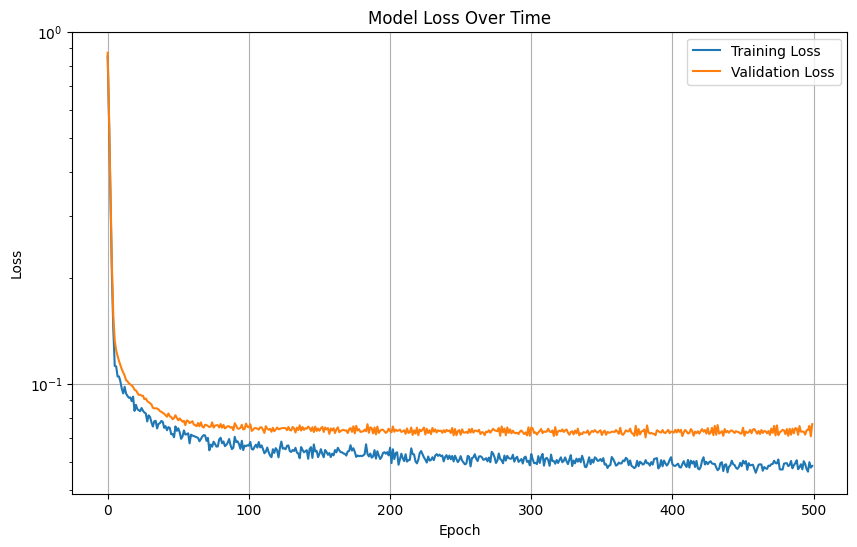

In [103]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.0005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store metrics
    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_train_loss:.6f}")
        print(f"Validation Loss: {avg_val_loss:.6f}")
        print("-" * 40)


    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Log scale often better for loss visualization
    plt.show()

    return train_losses, val_losses

# Example usage:
num_epochs = 500
learning_rate = 0.0001

# Create the model
model = SimpleRNNModel(input_size=window_size-1)

train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate
)

Validation MAE: 0.2135


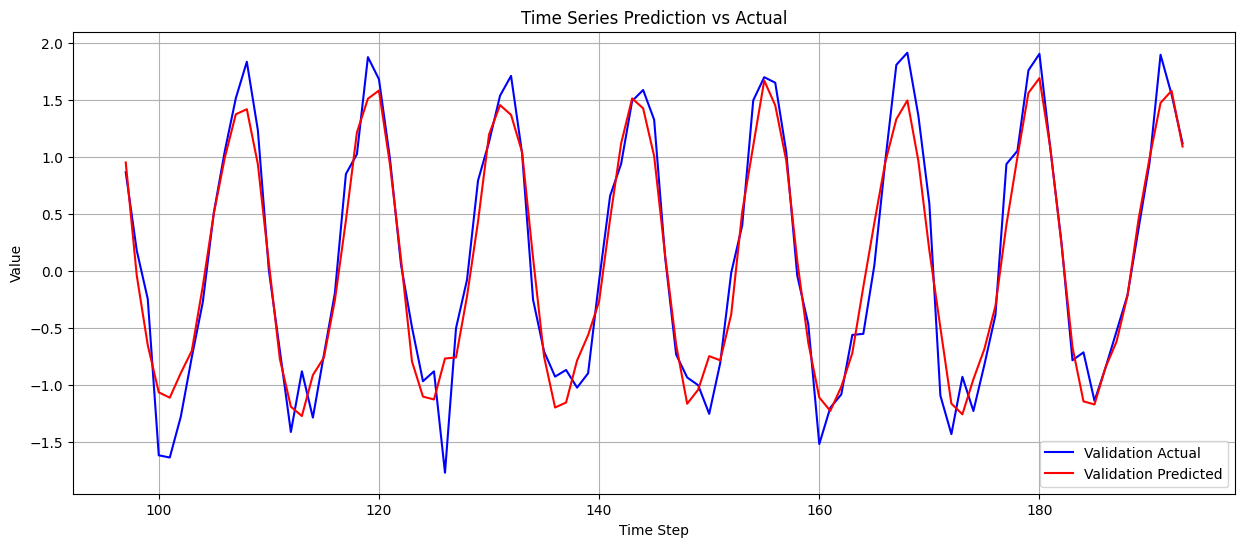

In [105]:
# Step 5 - Do predictions
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def evaluate_predictions(model, loader):
    """Generate predictions and calculate metrics"""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    predictions = np.array(all_predictions)
    targets = np.array(all_targets)


    # Calculate metrics
    mae = mean_absolute_error(targets, predictions)

    return predictions, targets, mae

def plot_predictions(val_pred, val_true):
    """Plot the predictions against actual values"""
    plt.figure(figsize=(15, 6))


    # Plot validation data
    offset = len(val_true)
    plt.plot(range(offset, offset + len(val_true)), val_true, 'b-', label='Validation Actual')
    plt.plot(range(offset, offset + len(val_pred)), val_pred, 'r-', label='Validation Predicted')



    plt.title('Time Series Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# After training your model:
# Generate predictions
val_predictions, val_targets, val_mae = evaluate_predictions(model, val_loader)

# Print metrics
print(f"Validation MAE: {val_mae:.4f}")

# Plot results
plot_predictions(val_predictions, val_targets)
